In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)



<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

In [2]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/3d_poly_fully/results/"
    case_name = "M_450_20k_fully"
    npy_file_name_aniso = f"p_ori_fully5d_fz_aveE_f1.0_t0.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95.npy"
    npy_file_name_aniso_energy = f"p_ori_fully5d_fz_aveE_f1.0_t0.0_450_20k_multiCore64_J1_refer_1_0_0_seed56689_kt1.95_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} energy data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

The M_450_20k_fully data size is: (56, 450, 450, 450)
READING DATA DONE
The M_450_20k_fully energy data size is: (56, 450, 450, 450)
READING ENERGY DATA DONE


In [3]:
step_1000grains = 39
len(np.unique(npy_file_aniso[39,:]))

1011

In [4]:
    # YOU should remove the very small GB due to the less impact on curvature study
    # YOU should use different accuracy algorithm on voxels around the TJs.
    # A potential error: some small spherical GB are generated around large GB with same GB id
    
    
    step_num=51
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/3D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/3D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name,allow_pickle=True)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix.item())
            else:
                # cores = 128
                # loop_times = 5
                # R = np.zeros((size_x,size_y,size_z,4))
                # smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,current_microstructure,R,'p',verification_system = False,curvature_sign = True)
                # smoothing_class.linear3d_main("curvature")
                # C_ln = smoothing_class.get_C()
                # curvature_matrix = C_ln[1,:]
                # curvature_matrix_list.append(curvature_matrix)
                curvature_matrix = post_processing.IO_curvature(current_microstructure)
                # save curvature information
                np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                        GB_infomation_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    
                    # calculate or extract curvature
                    if pair_id not in curvature_matrix: continue
                    GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[pair_id][3]])
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)
            
            
            

100%|██████████| 51/51 [00:07<00:00,  6.94it/s]


In [5]:
    # GB Energy information
    step_num=51
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/3D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # # Get TJ and QJ information first
            # TJ_infomation_dict = dict()
            # for index, result in np.ndenumerate(current_microstructure):
            #     i,j,k = index
            #     ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
            #     if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
            #          ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
            #         central_site = int(current_microstructure[i,j,k])
            #         neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
            #         neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
            #         if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
            #         neighboring_sites_list_unque = list(neighboring_sites_set)
            #         # remove the TJs and QJs
            #         if len(neighboring_sites_list_unque) > 1: 
            #             for m in range(len(neighboring_sites_list_unque)):
            #                 pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
            #                 if pair_id in TJ_infomation_dict:
            #                     tmp = TJ_infomation_dict[pair_id]
            #                     tmp.append([i,j,k])
            #                     TJ_infomation_dict[pair_id] = tmp
            #                 else: 
            #                     TJ_infomation_dict[pair_id] = [[i,j,k]]
            # print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 1 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm,kp,km = myInput.periodic_bc3d(size_x,size_y,size_z,i,j,k)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,j,kp]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,j,km]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[i,j,kp], current_microstructure[im,j,k], current_microstructure[i,jm,k], current_microstructure[i,j,km]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k],
                                                            current_microstructure[i,j,km], current_microstructure[ip,jp,km], current_microstructure[ip,j,km], current_microstructure[ip,jm,km], current_microstructure[i,jp,km], current_microstructure[i,jm,km], current_microstructure[im,jp,km], current_microstructure[im,j,km], current_microstructure[im,jm,km],
                                                            current_microstructure[i,j,kp], current_microstructure[ip,jp,kp], current_microstructure[ip,j,kp], current_microstructure[ip,jm,kp], current_microstructure[i,jp,kp], current_microstructure[i,jm,kp], current_microstructure[im,jp,kp], current_microstructure[im,j,kp], current_microstructure[im,jm,kp]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                        GBenergy_information_dict[pair_id][0] += 1 # GB area
                    else:
                        GB_infomation = np.array([1,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    # remove the TJs and QJs
                    # if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # # CONTINUE...    # remove the voxels around TJs and QJs
                    # # check the GB voxels is close to TJ or not
                    # break_point = 0
                    # if pair_id in TJ_infomation_dict:
                    #     for TJ_site in TJ_infomation_dict[pair_id]:
                    #         TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                    #         if TJ_distance < TJ_distance_max: 
                    #             break_point = 1
                    #             break
                    # if break_point == 1: continue
                    # calculate or extract GB energy
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

100%|██████████| 51/51 [00:08<00:00,  6.37it/s]


In [6]:
    from numba import njit, prange
    import multiprocessing as mp
    
    @njit(parallel=True)
    def compute_dV(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2)
    
    @njit(parallel=True)
    def compute_dV_split(npy_file_aniso_current,npy_file_aniso_next, pair_id_pair):
        growth_direction1 = (npy_file_aniso_current == pair_id_pair[0]) & (npy_file_aniso_next == pair_id_pair[1])
        growth_direction2 = (npy_file_aniso_current == pair_id_pair[1]) & (npy_file_aniso_next == pair_id_pair[0])
        return np.sum(growth_direction1) - np.sum(growth_direction2), np.sum(growth_direction1), np.sum(growth_direction2)
    
    def compute_necessary_info(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV = compute_dV(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    def compute_necessary_info_split(key,time_interval,
                               GB_infomation_dict_list_one_step_one_key,
                               GBenergy_information_dict_list_one_step_one_key,
                               npy_file_aniso_current,
                               npy_file_aniso_next):
        
        
        # Calculate dV and velocity
        dV, dV_direction1, dV_direction2 = compute_dV_split(npy_file_aniso_current,npy_file_aniso_next,GB_infomation_dict_list_one_step_one_key[6:8])
        velocity = dV/time_interval/(GB_infomation_dict_list_one_step_one_key[5]/2)
        # keep curvature
        current_curvature_value = GB_infomation_dict_list_one_step_one_key[4]
        # keep GB energy
        current_eng = GBenergy_information_dict_list_one_step_one_key[4]
        
        result = {
            "key": key,
            "velocity": velocity,
            "dV_direction1": dV_direction1,
            "dV_direction2": dV_direction2,
            "current_curvature_value": current_curvature_value,
            "current_eng": current_eng,
            "is_anti_curvature": current_curvature_value * velocity < -0.0001
        }
        
        return result
    
    # if __name__ == '__main__':
    time_interval = 2
    curvature_limit = 0.00794
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    GB_list_area_list = []
    GB_list_dV_direction1 = []
    GB_list_dV_direction2 = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    dV_dict = []
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_area_list_tmp = []
        GB_list_dV_direction1_tmp = []
        GB_list_dV_direction2_tmp = []
        key_set = set()

        # MP
        # remove disappeared GBs and low area GBs and remove low curvature
        print(f"key num start with {len(GB_infomation_dict_list[time_step])}")
        tmp_GB_infomation_dict_for_mp = {}
        tmp_GBenergy_information_dict_for_mp = {}
        for key in GB_infomation_dict_list[time_step]:
            if (GB_infomation_dict_list[time_step][key][5] < 100 or 
                GB_infomation_dict_list[time_step+1].get(key) is None or 
                abs(GB_infomation_dict_list[time_step][key][4]) < curvature_limit): 
                continue
            tmp_GB_infomation_dict_for_mp[key] = GB_infomation_dict_list[time_step][key]
            tmp_GBenergy_information_dict_for_mp[key] = GBenergy_information_dict_list[time_step][key]
        print(f"key num end with {len(tmp_GB_infomation_dict_for_mp)}")
        # run key
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + dV_dict_file_name):
            npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
            dV_dict_tmp = npz_file["dV_dict_tmp"]
            dV_dict_tmp=dV_dict_tmp.item()
        else:
            dV_dict_tmp = {}
        for key in tqdm(tmp_GB_infomation_dict_for_mp):
            if key in dV_dict_tmp:
                result = dV_dict_tmp[key]
            else:
                result = compute_necessary_info_split(key,time_interval,tmp_GB_infomation_dict_for_mp[key],tmp_GBenergy_information_dict_for_mp[key],npy_file_aniso[time_step],npy_file_aniso[time_step+1])
                dV_dict_tmp[key] = result
            
            # Store these results remove ways-area,lowCurvature
            GB_list_velocity_list_tmp.append(result["velocity"])
            GB_list_curvature_list_tmp.append(result["current_curvature_value"])
            GB_list_GBenergy_list_tmp.append(result["current_eng"])
            GB_list_dV_direction1_tmp.append(result["dV_direction1"])
            GB_list_dV_direction2_tmp.append(result["dV_direction2"])
            
            # calculate GB area and store it
            current_GB_area = 0.5*tmp_GB_infomation_dict_for_mp[key][0]
            GB_list_area_list_tmp.append(current_GB_area)


            # keep anti-curvature GB info
            if result["is_anti_curvature"]: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        if not os.path.exists(data_file_folder + dV_dict_file_name):
            np.savez(data_file_folder + dV_dict_file_name, dV_dict_tmp=dV_dict_tmp)

        # keep all GBs after ways-area,lowCurvature
        dV_dict.append(dV_dict_tmp)
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        GB_list_area_list.append(GB_list_area_list_tmp)
        GB_list_dV_direction1.append(GB_list_dV_direction1_tmp)
        GB_list_dV_direction2.append(GB_list_dV_direction2_tmp)

        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        # # filter the anti-curvature GB with 11111
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]&GB_filter_kernel[1]&GB_filter_kernel[3]&GB_filter_kernel[4]&GB_filter_kernel[2])
        # # filter the anti-curvature GB with 00100
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 01100
        # filtered_set1 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[3]|GB_filter_kernel[4])
        # # filter the anti-curvature GB with 00110
        # filtered_set2 = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[4])
        # filtered_set = filtered_set0|filtered_set1|filtered_set2
        # # filter the anti-curvature GB with 010
        # filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[1]|GB_filter_kernel[3])
        
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")


    # filter the GBs in GB_id_focus without anti-curvature behavior after 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)

    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])


key num start with 140856
key num end with 50365


100%|██████████| 50365/50365 [00:00<00:00, 316257.07it/s]


finish 0 with num of GBs 50365, and collected num of GBs 20029
key num start with 141144
key num end with 63531


100%|██████████| 63531/63531 [00:00<00:00, 251266.46it/s]


finish 1 with num of GBs 63531, and collected num of GBs 52739
key num start with 130491
key num end with 59101


100%|██████████| 59101/59101 [00:00<00:00, 292346.78it/s]


finish 2 with num of GBs 59101, and collected num of GBs 68724
key num start with 116744
key num end with 53459


100%|██████████| 53459/53459 [00:00<00:00, 427372.03it/s]


finish 3 with num of GBs 53459, and collected num of GBs 78294
key num start with 102590
key num end with 47445


100%|██████████| 47445/47445 [00:00<00:00, 420713.51it/s]


finish 4 with num of GBs 47445, and collected num of GBs 85055
key num start with 89474
key num end with 42481


100%|██████████| 42481/42481 [00:00<00:00, 259844.12it/s]


finish 5 with num of GBs 42481, and collected num of GBs 90172
key num start with 78314
key num end with 37977


100%|██████████| 37977/37977 [00:00<00:00, 251799.07it/s]


finish 6 with num of GBs 37977, and collected num of GBs 94346
key num start with 68348
key num end with 33953


100%|██████████| 33953/33953 [00:00<00:00, 271475.39it/s]


finish 7 with num of GBs 33953, and collected num of GBs 97786
key num start with 59812
key num end with 30426


100%|██████████| 30426/30426 [00:00<00:00, 303784.44it/s]


finish 8 with num of GBs 30426, and collected num of GBs 100882
key num start with 52864
key num end with 27485


100%|██████████| 27485/27485 [00:00<00:00, 325790.86it/s]


finish 9 with num of GBs 27485, and collected num of GBs 103351
key num start with 47154
key num end with 25100


100%|██████████| 25100/25100 [00:00<00:00, 359036.46it/s]


finish 10 with num of GBs 25100, and collected num of GBs 105436
key num start with 42266
key num end with 22577


100%|██████████| 22577/22577 [00:00<00:00, 356781.49it/s]


finish 11 with num of GBs 22577, and collected num of GBs 107113
key num start with 37982
key num end with 20257


100%|██████████| 20257/20257 [00:00<00:00, 319262.36it/s]


finish 12 with num of GBs 20257, and collected num of GBs 108667
key num start with 34084
key num end with 18738


100%|██████████| 18738/18738 [00:00<00:00, 273738.78it/s]


finish 13 with num of GBs 18738, and collected num of GBs 109946
key num start with 31015
key num end with 17054


100%|██████████| 17054/17054 [00:00<00:00, 271188.11it/s]


finish 14 with num of GBs 17054, and collected num of GBs 111081
key num start with 28055
key num end with 15520


100%|██████████| 15520/15520 [00:00<00:00, 284144.86it/s]


finish 15 with num of GBs 15520, and collected num of GBs 112027
key num start with 25597
key num end with 14593


100%|██████████| 14593/14593 [00:00<00:00, 357171.91it/s]


finish 16 with num of GBs 14593, and collected num of GBs 112881
key num start with 23672
key num end with 13465


100%|██████████| 13465/13465 [00:00<00:00, 367693.84it/s]


finish 17 with num of GBs 13465, and collected num of GBs 113583
key num start with 22017
key num end with 12486


100%|██████████| 12486/12486 [00:00<00:00, 357853.56it/s]


finish 18 with num of GBs 12486, and collected num of GBs 114202
key num start with 20396
key num end with 11407


100%|██████████| 11407/11407 [00:00<00:00, 357050.62it/s]


finish 19 with num of GBs 11407, and collected num of GBs 114762
key num start with 18927
key num end with 10755


100%|██████████| 10755/10755 [00:00<00:00, 356587.46it/s]


finish 20 with num of GBs 10755, and collected num of GBs 115259
key num start with 17546
key num end with 9963


100%|██████████| 9963/9963 [00:00<00:00, 336822.24it/s]


finish 21 with num of GBs 9963, and collected num of GBs 115682
key num start with 16500
key num end with 9399


100%|██████████| 9399/9399 [00:00<00:00, 361380.38it/s]


finish 22 with num of GBs 9399, and collected num of GBs 116068
key num start with 15439
key num end with 8829


100%|██████████| 8829/8829 [00:00<00:00, 340197.42it/s]


finish 23 with num of GBs 8829, and collected num of GBs 116412
key num start with 14522
key num end with 8332


100%|██████████| 8332/8332 [00:00<00:00, 295584.38it/s]


finish 24 with num of GBs 8332, and collected num of GBs 116743
key num start with 13722
key num end with 7858


100%|██████████| 7858/7858 [00:00<00:00, 349833.26it/s]


finish 25 with num of GBs 7858, and collected num of GBs 117011
key num start with 13021
key num end with 7501


100%|██████████| 7501/7501 [00:00<00:00, 370942.34it/s]


finish 26 with num of GBs 7501, and collected num of GBs 117264
key num start with 12317
key num end with 7054


100%|██████████| 7054/7054 [00:00<00:00, 390804.29it/s]


finish 27 with num of GBs 7054, and collected num of GBs 117510
key num start with 11669
key num end with 6700


100%|██████████| 6700/6700 [00:00<00:00, 353331.11it/s]


finish 28 with num of GBs 6700, and collected num of GBs 117740
key num start with 11055
key num end with 6304


100%|██████████| 6304/6304 [00:00<00:00, 341626.84it/s]


finish 29 with num of GBs 6304, and collected num of GBs 117930
key num start with 10508
key num end with 6002


100%|██████████| 6002/6002 [00:00<00:00, 334563.26it/s]


finish 30 with num of GBs 6002, and collected num of GBs 118109
key num start with 10024
key num end with 5682


100%|██████████| 5682/5682 [00:00<00:00, 337894.48it/s]


finish 31 with num of GBs 5682, and collected num of GBs 118282
key num start with 9556
key num end with 5479


100%|██████████| 5479/5479 [00:00<00:00, 343409.07it/s]


finish 32 with num of GBs 5479, and collected num of GBs 118433
key num start with 9132
key num end with 5264


100%|██████████| 5264/5264 [00:00<00:00, 368047.75it/s]


finish 33 with num of GBs 5264, and collected num of GBs 118566
key num start with 8759
key num end with 4850


100%|██████████| 4850/4850 [00:00<00:00, 315151.12it/s]


finish 34 with num of GBs 4850, and collected num of GBs 118711
key num start with 8328
key num end with 4677


100%|██████████| 4677/4677 [00:00<00:00, 357129.38it/s]

finish 35 with num of GBs 4677, and collected num of GBs 118834
key num start with 7927


key num end with 4511


100%|██████████| 4511/4511 [00:00<00:00, 360926.81it/s]


finish 36 with num of GBs 4511, and collected num of GBs 118955
key num start with 7589
key num end with 4263


100%|██████████| 4263/4263 [00:00<00:00, 322516.56it/s]


finish 37 with num of GBs 4263, and collected num of GBs 119081
key num start with 7278
key num end with 4103


100%|██████████| 4103/4103 [00:00<00:00, 342220.24it/s]


finish 38 with num of GBs 4103, and collected num of GBs 119188
key num start with 6990
key num end with 3965


100%|██████████| 3965/3965 [00:00<00:00, 350305.75it/s]


finish 39 with num of GBs 3965, and collected num of GBs 119277
key num start with 6787
key num end with 3715


100%|██████████| 3715/3715 [00:00<00:00, 343151.85it/s]


finish 40 with num of GBs 3715, and collected num of GBs 119366
key num start with 6501
key num end with 3569


100%|██████████| 3569/3569 [00:00<00:00, 228234.91it/s]


finish 41 with num of GBs 3569, and collected num of GBs 119461
key num start with 6247
key num end with 3525


100%|██████████| 3525/3525 [00:00<00:00, 279514.54it/s]


finish 42 with num of GBs 3525, and collected num of GBs 119550
key num start with 6005
key num end with 3361


100%|██████████| 3361/3361 [00:00<00:00, 311193.28it/s]

finish 43 with num of GBs 3361, and collected num of GBs 119630
key num start with 5849


key num end with 3193


100%|██████████| 3193/3193 [00:00<00:00, 287273.70it/s]


finish 44 with num of GBs 3193, and collected num of GBs 119709
key num start with 5682
key num end with 3126


100%|██████████| 3126/3126 [00:00<00:00, 297898.22it/s]


finish 45 with num of GBs 3126, and collected num of GBs 119768
key num start with 5483
key num end with 3066


100%|██████████| 3066/3066 [00:00<00:00, 297561.98it/s]


finish 46 with num of GBs 3066, and collected num of GBs 119833
key num start with 5320
key num end with 2995


100%|██████████| 2995/2995 [00:00<00:00, 299293.35it/s]


finish 47 with num of GBs 2995, and collected num of GBs 119908
key num start with 5145
key num end with 2924


100%|██████████| 2924/2924 [00:00<00:00, 613575.39it/s]

finish 48 with num of GBs 2924, and collected num of GBs 119908
key num start with 4973


key num end with 2719


100%|██████████| 2719/2719 [00:00<00:00, 590866.41it/s]


finish 49 with num of GBs 2719, and collected num of GBs 119908


In [7]:
len(GB_id_focus_copy)

119908

In [8]:
    time_interval = 2
    # anti_c GBs grabing
    GB_antic_list_velocity_AllList = []
    GB_antic_list_curvature_AllList = []
    GB_antic_list_GBenergy_AllList = []
    GB_antic_list_anticNum_AllList = []
    GB_antic_list_area_AllList = []
    GB_antic_list_dV_normD_AllList = []
    GB_antic_list_dV_antiD_AllList = []
    
    GB_antic_list_velocity_list = []
    GB_antic_list_curvature_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_antic_list_area_list = []
    GB_antic_list_dV_normD_list = []
    GB_antic_list_dV_antiD_list = []
    
    # norn_c GBs grabing
    GB_normc_list_velocity_AllList = []
    GB_normc_list_curvature_AllList = []
    GB_normc_list_GBenergy_AllList = []
    GB_normc_list_area_AllList = []
    GB_normc_list_dV_normD_AllList = []
    GB_normc_list_dV_antiD_AllList = []
    
    GB_normc_list_velocity_list = []
    GB_normc_list_curvature_list = []
    GB_normc_list_GBenergy_list = []
    GB_normc_list_area_list = []
    GB_normc_list_dV_normD_list = []
    GB_normc_list_dV_antiD_list = []
    for time_step in tqdm(range(step_num)):
        if time_step+1 >= step_num: continue
        # read the info data
        dV_dict_file_name = f"GB_velocity_data/3D_dV_split_data_{case_name}_step{time_step}.npz"
        npz_file = np.load(data_file_folder + dV_dict_file_name,allow_pickle=True)
        dV_dict_tmp = npz_file["dV_dict_tmp"]
        dV_dict_tmp = dV_dict_tmp.item()
        
        tmp_GB_antic_list_velocity = []
        tmp_GB_antic_list_curvature = []
        tmp_GB_antic_list_GBenergy = []
        tmp_GB_antic_list_anticNum = []
        tmp_GB_antic_list_area = []
        tmp_GB_antic_list_dV_normD = []
        tmp_GB_antic_list_dV_antiD = []
        
        # anti_c
        for key in GB_id_focus_detail:
            if time_step in GB_id_focus_detail[key]:
                
                result = dV_dict_tmp[key]
                velocity = result["velocity"]
                current_curvature_value = result["current_curvature_value"]
                current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
                dV_direction1 = result["dV_direction1"]
                dV_direction2 = result["dV_direction2"]
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_antic_list_velocity_list.append(-velocity)
                    GB_antic_list_curvature_list.append(-current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction2)
                    GB_antic_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_antic_list_velocity.append(-velocity)
                    tmp_GB_antic_list_curvature.append(-current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction2)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_antic_list_velocity_list.append(velocity)
                    GB_antic_list_curvature_list.append(current_curvature_value)
                    GB_antic_list_dV_normD_list.append(dV_direction1)
                    GB_antic_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_antic_list_velocity.append(velocity)
                    tmp_GB_antic_list_curvature.append(current_curvature_value)
                    tmp_GB_antic_list_dV_normD.append(dV_direction1)
                    tmp_GB_antic_list_dV_antiD.append(dV_direction2)
                GB_antic_list_GBenergy_list.append(result["current_eng"])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
                GB_antic_list_area_list.append(current_area)
                tmp_GB_antic_list_GBenergy.append(result["current_eng"])
                tmp_GB_antic_list_anticNum.append(GB_id_focus[key])
                tmp_GB_antic_list_area.append(current_area)
            
        GB_antic_list_velocity_AllList.append(tmp_GB_antic_list_velocity)
        GB_antic_list_curvature_AllList.append(tmp_GB_antic_list_curvature)
        GB_antic_list_GBenergy_AllList.append(tmp_GB_antic_list_GBenergy)
        GB_antic_list_anticNum_AllList.append(tmp_GB_antic_list_anticNum)
        GB_antic_list_area_AllList.append(tmp_GB_antic_list_area)
        GB_antic_list_dV_normD_AllList.append(tmp_GB_antic_list_dV_normD)
        GB_antic_list_dV_antiD_AllList.append(tmp_GB_antic_list_dV_antiD)
        
        # norm c
        tmp_GB_normc_list_velocity = []
        tmp_GB_normc_list_curvature = []
        tmp_GB_normc_list_GBenergy = []
        tmp_GB_normc_list_area = []
        tmp_GB_normc_list_dV_normD = []
        tmp_GB_normc_list_dV_antiD = []
        
        for key in dV_dict_tmp:
            result = dV_dict_tmp[key]
            velocity = result["velocity"]
            current_curvature_value = result["current_curvature_value"]
            current_area = 0.5*GB_infomation_dict_list[time_step][key][0]
            dV_direction1 = result["dV_direction1"]
            dV_direction2 = result["dV_direction2"]
            if current_curvature_value * velocity > 0: # norm c
                
                # change the sign of the velocity by curvature
                if current_curvature_value < 0: 
                    GB_normc_list_velocity_list.append(-velocity)
                    GB_normc_list_curvature_list.append(-current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction2)
                    GB_normc_list_dV_antiD_list.append(dV_direction1)
                    tmp_GB_normc_list_velocity.append(-velocity)
                    tmp_GB_normc_list_curvature.append(-current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction2)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction1)
                else: 
                    GB_normc_list_velocity_list.append(velocity)
                    GB_normc_list_curvature_list.append(current_curvature_value)
                    GB_normc_list_dV_normD_list.append(dV_direction1)
                    GB_normc_list_dV_antiD_list.append(dV_direction2)
                    tmp_GB_normc_list_velocity.append(velocity)
                    tmp_GB_normc_list_curvature.append(current_curvature_value)
                    tmp_GB_normc_list_dV_normD.append(dV_direction1)
                    tmp_GB_normc_list_dV_antiD.append(dV_direction2)
                GB_normc_list_GBenergy_list.append(result["current_eng"])
                GB_normc_list_area_list.append(current_area)
                tmp_GB_normc_list_GBenergy.append(result["current_eng"])
                tmp_GB_normc_list_area.append(current_area)
        
        GB_normc_list_velocity_AllList.append(tmp_GB_normc_list_velocity)
        GB_normc_list_curvature_AllList.append(tmp_GB_normc_list_curvature)
        GB_normc_list_GBenergy_AllList.append(tmp_GB_normc_list_GBenergy)
        GB_normc_list_area_AllList.append(tmp_GB_normc_list_area)
        GB_normc_list_dV_normD_AllList.append(tmp_GB_normc_list_dV_normD)
        GB_normc_list_dV_antiD_AllList.append(tmp_GB_normc_list_dV_antiD)
                
            
        
            

100%|██████████| 51/51 [00:08<00:00,  5.88it/s]


In [9]:
    print("anti-c GB")
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_velocity_list)}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    print("anti-c GB in real total number")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_antic_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print(f"The ratio of norm-curvature GBs during whole simulations is {len(GB_normc_list_velocity_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("Over all voxels")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    for i in range(0,len(GB_list_curvature_list)): 
        for j in range(len(GB_list_curvature_list[i])):
            # in general, curvature>0, V_d1 is the voxel in curvature direction, while V_d1 is anti-c when curvature<0
            if GB_list_curvature_list[i][j]<0: 
                normal_growth_voxel += GB_list_dV_direction2[i][j]
                antic_growth_voxel += GB_list_dV_direction1[i][j]
            elif GB_list_curvature_list[i][j]>=0: 
                normal_growth_voxel += GB_list_dV_direction1[i][j]
                antic_growth_voxel += GB_list_dV_direction2[i][j]
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")


anti-c GB
The number of the GBs showing anti-curvature during whole simulations is 455573
The ratio of anti-curvature GBs during whole simulations is 28.71627009265265% in 1586463 GBs
The ratio of norm-curvature GBs during whole simulations is 15.670645958966581% in 1586463 GBs

anti-c GB in real total number
The ratio of anti-curvature GBs during whole simulations is 64.69534864566263% in 704182 GBs
The ratio of norm-curvature GBs during whole simulations is 35.30465135433737% in 704182 GBs

Over all voxels
The number of the normal voxels and antic voxels during whole simulations are 44513237 and 140238008
The ratio of anti-curvature voxels during whole simulations is 75.90639402727706% in 184751245 voxels

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 8699883 and 121007629
The ratio of anti-curvature voxels during whole simulations is 93.29269148266447% in 129707512 voxels
Voxels on norm-c GBs
The number of the normal voxels and an

<Figure size 432x288 with 0 Axes>

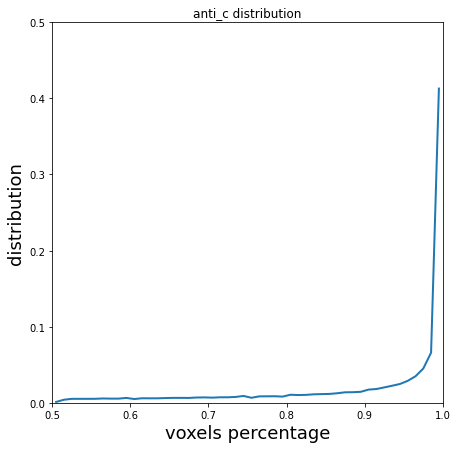

<Figure size 432x288 with 0 Axes>

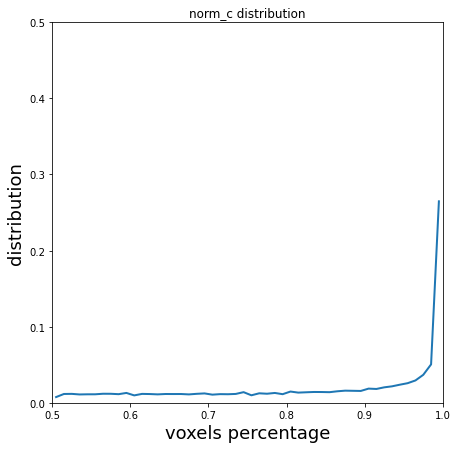

In [10]:
    # voxels information in anti-c GBs --- Yes I think it can be confidence!!!!!!
    bin_interval = 0.01
    x_lim = [0.5,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    Antic_voxel_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    antic_voxel_num_bin = np.zeros(bin_number)
    normc_voxel_num_bin = np.zeros(bin_number)
    for index in range(len(GB_antic_list_dV_normD_list)):
        antic_voxel_num_bin[int((GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    for index in range(len(GB_normc_list_dV_normD_list)):
        normc_voxel_num_bin[int((GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index])-x_lim[0])//bin_interval)] += 1
    # plot
    figure_name_all_bin = f"figures/3D_antic_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("anti_c distribution")
    plt.plot(Antic_voxel_coordinate, antic_voxel_num_bin/np.sum(antic_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    figure_name_all_bin = f"figures/3D_normc_voxel_distribution_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.5,1.0])
    plt.ylim([0,0.5])
    plt.title("norm_c distribution")
    plt.plot(Antic_voxel_coordinate, normc_voxel_num_bin/np.sum(normc_voxel_num_bin),'-', linewidth=2)
    plt.xlabel("voxels percentage", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
        
    confidence_factor = 0.99
    
    update_GB_antic_list_velocity_AllList = []
    update_GB_antic_list_curvature_AllList = []
    update_GB_antic_list_GBenergy_AllList = []
    update_GB_antic_list_anticNum_AllList = []
    update_GB_antic_list_area_AllList = []
    update_GB_antic_list_dV_normD_AllList = []
    update_GB_antic_list_dV_antiD_AllList = []
    
    update_GB_antic_list_velocity_list = []
    update_GB_antic_list_curvature_list = []
    update_GB_antic_list_GBenergy_list = []
    update_GB_antic_list_anticNum_list = []
    update_GB_antic_list_area_list = []
    update_GB_antic_list_dV_normD_list = []
    update_GB_antic_list_dV_antiD_list = []
    for index in range(len(GB_antic_list_velocity_list)):
        if GB_antic_list_dV_antiD_list[index]/(GB_antic_list_dV_normD_list[index]+GB_antic_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_antic_list_velocity_list.append(GB_antic_list_velocity_list[index])
            update_GB_antic_list_curvature_list.append(GB_antic_list_curvature_list[index])
            update_GB_antic_list_GBenergy_list.append(GB_antic_list_GBenergy_list[index])
            update_GB_antic_list_anticNum_list.append(GB_antic_list_anticNum_list[index])
            update_GB_antic_list_area_list.append(GB_antic_list_area_list[index])
            update_GB_antic_list_dV_normD_list.append(GB_antic_list_dV_normD_list[index])
            update_GB_antic_list_dV_antiD_list.append(GB_antic_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_antic_list_velocity_AllList)):
        tmp_update_GB_antic_list_velocity_AllList =[]
        tmp_update_GB_antic_list_curvature_AllList =[]
        tmp_update_GB_antic_list_GBenergy_AllList = []
        tmp_update_GB_antic_list_anticNum_AllList = []
        tmp_update_GB_antic_list_area_AllList = []
        tmp_update_GB_antic_list_dV_normD_AllList = []
        tmp_update_GB_antic_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_antic_list_velocity_AllList[index_i])):
            if GB_antic_list_dV_antiD_AllList[index_i][index_j]/(GB_antic_list_dV_normD_AllList[index_i][index_j]+GB_antic_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_antic_list_velocity_AllList.append(GB_antic_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_antic_list_curvature_AllList.append(GB_antic_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_antic_list_GBenergy_AllList.append(GB_antic_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_antic_list_anticNum_AllList.append(GB_antic_list_anticNum_AllList[index_i][index_j])
                tmp_update_GB_antic_list_area_AllList.append(GB_antic_list_area_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_normD_AllList.append(GB_antic_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_antic_list_dV_antiD_AllList.append(GB_antic_list_dV_antiD_AllList[index_i][index_j])
        update_GB_antic_list_velocity_AllList.append(tmp_update_GB_antic_list_velocity_AllList)
        update_GB_antic_list_curvature_AllList.append(tmp_update_GB_antic_list_curvature_AllList)
        update_GB_antic_list_GBenergy_AllList.append(tmp_update_GB_antic_list_GBenergy_AllList)
        update_GB_antic_list_anticNum_AllList.append(tmp_update_GB_antic_list_anticNum_AllList)
        update_GB_antic_list_area_AllList.append(tmp_update_GB_antic_list_area_AllList)
        update_GB_antic_list_dV_normD_AllList.append(tmp_update_GB_antic_list_dV_normD_AllList)
        update_GB_antic_list_dV_antiD_AllList.append(tmp_update_GB_antic_list_dV_antiD_AllList)
        
        
    update_GB_normc_list_velocity_AllList = []
    update_GB_normc_list_curvature_AllList = []
    update_GB_normc_list_GBenergy_AllList = []
    update_GB_normc_list_area_AllList = []
    update_GB_normc_list_dV_normD_AllList = []
    update_GB_normc_list_dV_antiD_AllList = []
    
    update_GB_normc_list_velocity_list = []
    update_GB_normc_list_curvature_list = []
    update_GB_normc_list_GBenergy_list = []
    update_GB_normc_list_area_list = []
    update_GB_normc_list_dV_normD_list = []
    update_GB_normc_list_dV_antiD_list = []
    for index in range(len(GB_normc_list_velocity_list)):
        if GB_normc_list_dV_normD_list[index]/(GB_normc_list_dV_normD_list[index]+GB_normc_list_dV_antiD_list[index]) > confidence_factor:
            update_GB_normc_list_velocity_list.append(GB_normc_list_velocity_list[index])
            update_GB_normc_list_curvature_list.append(GB_normc_list_curvature_list[index])
            update_GB_normc_list_GBenergy_list.append(GB_normc_list_GBenergy_list[index])
            update_GB_normc_list_area_list.append(GB_normc_list_area_list[index])
            update_GB_normc_list_dV_normD_list.append(GB_normc_list_dV_normD_list[index])
            update_GB_normc_list_dV_antiD_list.append(GB_normc_list_dV_antiD_list[index])
    for index_i in range(len(update_GB_normc_list_velocity_AllList)):
        tmp_update_GB_normc_list_velocity_AllList =[]
        tmp_update_GB_normc_list_curvature_AllList =[]
        tmp_update_GB_normc_list_GBenergy_AllList = []
        tmp_update_GB_normc_list_area_AllList = []
        tmp_update_GB_normc_list_dV_normD_AllList = []
        tmp_update_GB_normc_list_dV_antiD_AllList = []
        for index_j in range(len(update_GB_normc_list_velocity_AllList[index_i])):
            if GB_normc_list_dV_normD_AllList[index_i][index_j]/(GB_normc_list_dV_normD_AllList[index_i][index_j]+GB_normc_list_dV_antiD_AllList[index_i][index_j]) > confidence_factor:
                tmp_update_GB_normc_list_velocity_AllList.append(GB_normc_list_velocity_AllList[index_i][index_j])
                tmp_update_GB_normc_list_curvature_AllList.append(GB_normc_list_curvature_AllList[index_i][index_j])
                tmp_update_GB_normc_list_GBenergy_AllList.append(GB_normc_list_GBenergy_AllList[index_i][index_j])
                tmp_update_GB_normc_list_area_AllList.append(GB_normc_list_area_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_normD_AllList.append(GB_normc_list_dV_normD_AllList[index_i][index_j])
                tmp_update_GB_normc_list_dV_antiD_AllList.append(GB_normc_list_dV_antiD_AllList[index_i][index_j])
        update_GB_normc_list_velocity_AllList.append(tmp_update_GB_normc_list_velocity_AllList)
        update_GB_normc_list_curvature_AllList.append(tmp_update_GB_normc_list_curvature_AllList)
        update_GB_normc_list_GBenergy_AllList.append(tmp_update_GB_normc_list_GBenergy_AllList)
        update_GB_normc_list_area_AllList.append(tmp_update_GB_normc_list_area_AllList)
        update_GB_normc_list_dV_normD_AllList.append(tmp_update_GB_normc_list_dV_normD_AllList)
        update_GB_normc_list_dV_antiD_AllList.append(tmp_update_GB_normc_list_dV_antiD_AllList)
        
            
    

In [11]:
    print("Voxels on anti-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_antic_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_antic_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of anti-curvature voxels during whole simulations is {antic_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()
    print("Voxels on norm-c GBs")
    normal_growth_voxel = 0
    antic_growth_voxel = 0
    # calculate anti-c voxels fraction
    normal_growth_voxel = np.sum(update_GB_normc_list_dV_normD_list)
    antic_growth_voxel = np.sum(update_GB_normc_list_dV_antiD_list)
    print(f"The number of the normal voxels and antic voxels during whole simulations are {normal_growth_voxel} and {antic_growth_voxel}")
    print(f"The ratio of norm-curvature voxels during whole simulations is {normal_growth_voxel/(antic_growth_voxel+normal_growth_voxel)*100}% in {antic_growth_voxel+normal_growth_voxel} voxels")
    print()

    print("anti-c GB before removing low fraction")
    total_GB_num = 0
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB_num += len(step_GB)
        
    total_GB_num_real = len(GB_antic_list_velocity_list) + len(GB_normc_list_velocity_list)

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_antic_list_dV_normD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(GB_antic_list_dV_normD_list)/total_GB_num_real*100}% and {len(GB_normc_list_dV_normD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print("anti-c GB after removing low fraction")

    # number of GB woth high anti-c fraction (99%)
    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(update_GB_antic_list_dV_antiD_list)}")
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is {len(update_GB_antic_list_dV_antiD_list)/total_GB_num_real*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num_real*100}% in {total_GB_num_real} GBs")
    print()
    
    print(f"The ratio of anti-curvature and norm GBs during whole simulations is (original GBs number) {len(update_GB_antic_list_dV_antiD_list)/total_GB_num*100}% and {len(update_GB_normc_list_dV_antiD_list)/total_GB_num*100}% in {total_GB_num} GBs")
    print()
    
    

Voxels on anti-c GBs
The number of the normal voxels and antic voxels during whole simulations are 88097 and 64043724
The ratio of anti-curvature voxels during whole simulations is 99.86263137608395% in 64131821 voxels

Voxels on norm-c GBs
The number of the normal voxels and antic voxels during whole simulations are 12694047 and 14594
The ratio of norm-curvature voxels during whole simulations is 99.88516474735576% in 12708641 voxels

anti-c GB before removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 455573
The ratio of anti-curvature and norm GBs during whole simulations is 64.69534864566263% and 35.30465135433737% in 704182 GBs

anti-c GB after removing low fraction
The number of the GBs showing anti-curvature during whole simulations is 188108
The ratio of anti-curvature and norm GBs during whole simulations is 26.712980451076568% and 9.346163349815814% in 704182 GBs

The ratio of anti-curvature and norm GBs during whole simulations is (

4.76258854517972


<Figure size 432x288 with 0 Axes>

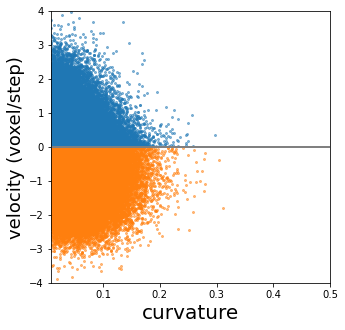

<Figure size 432x288 with 0 Axes>

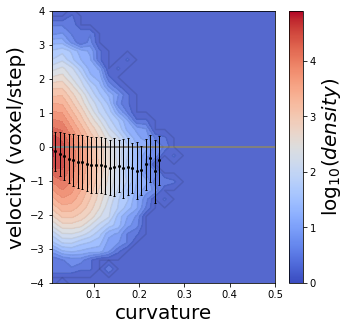

In [15]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(GB_normc_list_curvature_list, GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(GB_antic_list_curvature_list, GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.8, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(GB_normc_list_curvature_list+GB_antic_list_curvature_list, GB_normc_list_velocity_list+GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    # bin plot
    bin_interval = 0.01
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    curvature_bin_counts = np.zeros(bin_number)
    velocity_bin_sums = np.zeros(bin_number)
    velocity_bin_squared_sums = np.zeros(bin_number)

    new_curvature_1Dlist_remove_0step = GB_normc_list_curvature_list + GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = GB_normc_list_velocity_list + GB_antic_list_velocity_list

    for index in range(len(new_curvature_1Dlist_remove_0step)):
        curvature_val = new_curvature_1Dlist_remove_0step[index]
        velocity_val = new_velocity_1Dlist_remove_0step[index]
        if abs(curvature_val) > x_lim[1]:
            continue
        bin_idx = int((curvature_val - x_lim[0]) // bin_interval)
        curvature_bin_counts[bin_idx] += 1
        velocity_bin_sums[bin_idx] += velocity_val
        velocity_bin_squared_sums[bin_idx] += velocity_val ** 2

    velocity_bin_means = np.zeros(bin_number)
    velocity_bin_stds = np.zeros(bin_number)

    for i in range(bin_number):
        if curvature_bin_counts[i] > 0:
            velocity_bin_means[i] = velocity_bin_sums[i] / curvature_bin_counts[i]
            velocity_bin_stds[i] = np.sqrt((velocity_bin_squared_sums[i] / curvature_bin_counts[i]) - velocity_bin_means[i]**2)

    
    
    figure_name_all = f"figures/3D_velocity_signedcurvature_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 1
    print(np.max(np.log10(hist.T)))
    plt.contour(X, Y, np.log10(hist.T), levels=20, cmap='gray', alpha=0.1,vmin=0,vmax=4.9)
    plt.contourf(X, Y, np.log10(hist.T), levels=20, cmap='coolwarm', alpha=0.9,vmin=0,vmax=4.9)
    sm = plt.cm.ScalarMappable(cmap='coolwarm',norm=plt.Normalize(vmin=0,vmax=4.9))
    cbar = plt.colorbar(sm)
    cbar.set_label(u"$\log_{10}(density)$", fontsize=20)
    
    # plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o-', c='k', linewidth=1)
    valid_bins = curvature_bin_counts > 10
    plt.errorbar(curvature_coordinate[valid_bins], velocity_bin_means[valid_bins], yerr=velocity_bin_stds[valid_bins],
             fmt='o', color='k', linewidth=1, capsize=1, ecolor='black', markersize=2)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    


Text(0, 0.5, 'velocity (voxel/step)')

<Figure size 432x288 with 0 Axes>

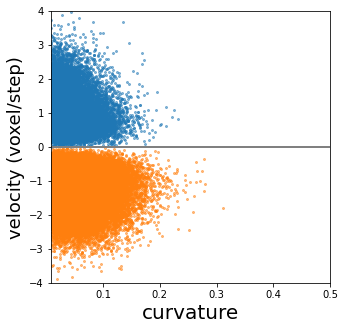

<Figure size 432x288 with 0 Axes>

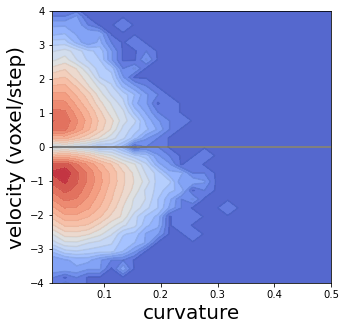

<Figure size 432x288 with 0 Axes>

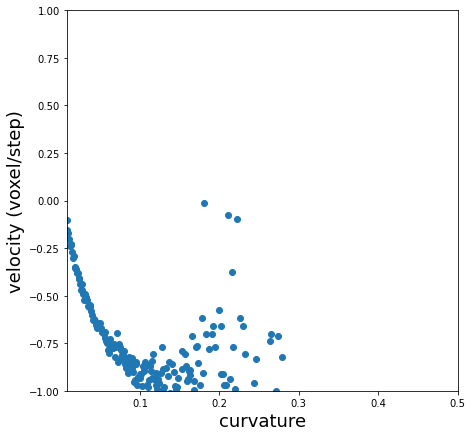

In [12]:
    # All in 1 figrue
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(update_GB_normc_list_curvature_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5)
    plt.scatter(update_GB_antic_list_curvature_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # hot figure
    # Create a 2D histogram to approximate density
    x_bins = np.linspace( 0, 0.8, 40)  # X-axis bins (adjust based on your data)
    y_bins = np.linspace(-5.0, 5.0, 40)  # Y-axis bins (adjust based on your data)
    hist, x_edges, y_edges = np.histogram2d(update_GB_normc_list_curvature_list+update_GB_antic_list_curvature_list, update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list, bins=[x_bins, y_bins])
    # Compute the bin centers
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    
    figure_name_all = f"figures/3D_velocity_signedcurvature_confi_hotUpdate_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.5],[0,0],'-',color='grey',linewidth=2)
    X, Y = np.meshgrid(x_centers, y_centers)
    hist.T[hist.T==0] = 0.5
    plt.contourf(X, Y, np.log(hist.T), levels=20, cmap='coolwarm', alpha=0.9)
    plt.contour(X, Y, np.log(hist.T), levels=20, cmap='gray', alpha=0.1)
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=20)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    new_curvature_1Dlist_remove_0step = update_GB_normc_list_curvature_list + update_GB_antic_list_curvature_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list + update_GB_antic_list_velocity_list
    for index in range(len(new_curvature_1Dlist_remove_0step)):
        if abs(new_curvature_1Dlist_remove_0step[index])>x_lim[1]: continue
        curvature_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_curvature_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.5])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


0.340188744239648


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

/apps/python/3.8/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


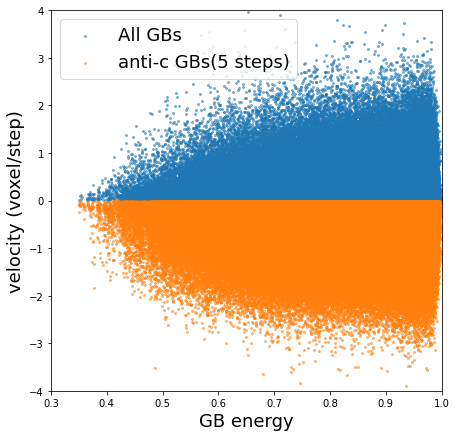

<Figure size 432x288 with 0 Axes>

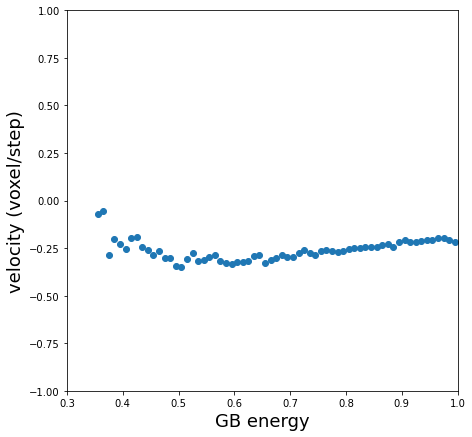

<Figure size 432x288 with 0 Axes>

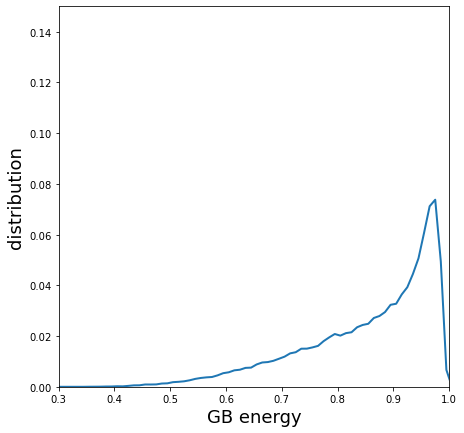

<Figure size 432x288 with 0 Axes>

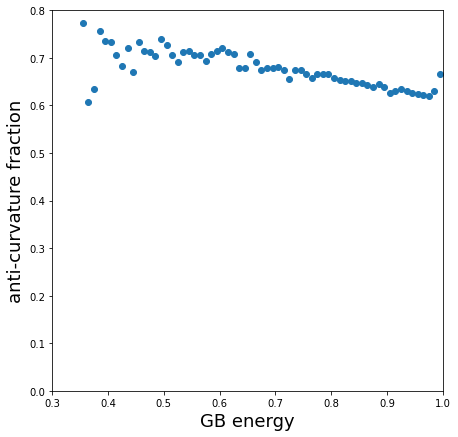

<Figure size 432x288 with 0 Axes>

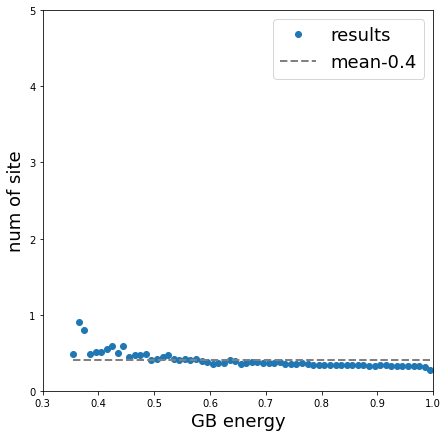

In [16]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GB_normc_list_GBenergy_list, GB_normc_list_velocity_list,s=4,alpha=0.5,label='All GBs')
    plt.scatter(GB_antic_list_GBenergy_list, GB_antic_list_velocity_list,s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.05]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    GBenergy_1Dlist_remove_0step = GB_normc_list_GBenergy_list+GB_antic_list_GBenergy_list
    velocity_1Dlist_remove_0step = GB_normc_list_velocity_list+GB_antic_list_velocity_list
    for index in range(len(GBenergy_1Dlist_remove_0step)):
        if abs(GBenergy_1Dlist_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_remove_0step[index]
        if int((GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_remove_0step[index])
    for index in range(len(GB_antic_list_GBenergy_list)):
        antic_num_bin[int((GB_antic_list_GBenergy_list[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


0.22788046384465377


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

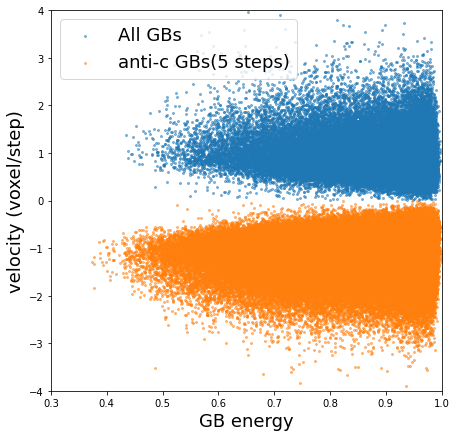

<Figure size 432x288 with 0 Axes>

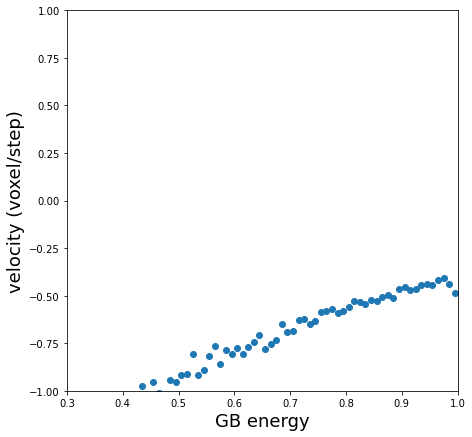

<Figure size 432x288 with 0 Axes>

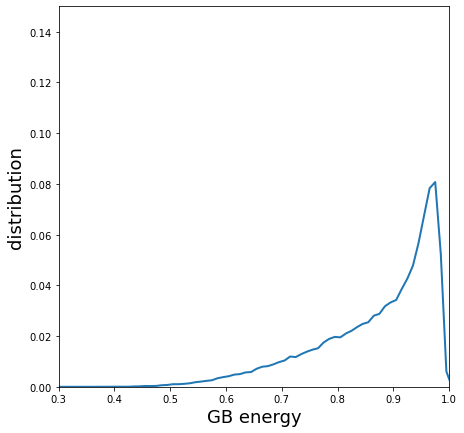

<Figure size 432x288 with 0 Axes>

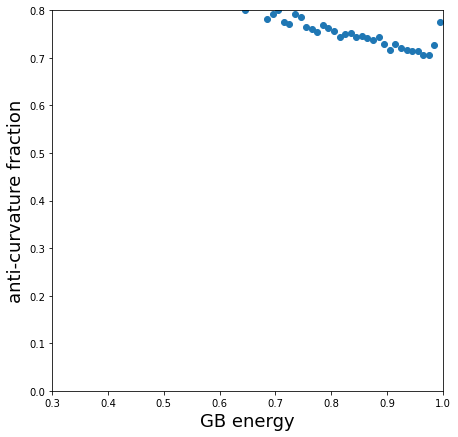

<Figure size 432x288 with 0 Axes>

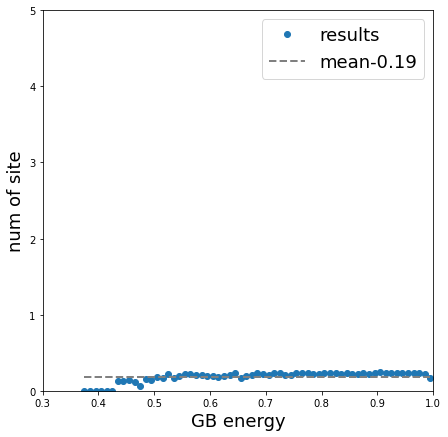

In [17]:

    figure_name_all = f"figures/3D_velocity_GBenergy_confi_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5,label='All GBs')
    # GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    # GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    # GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    # plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.scatter(update_GB_normc_list_GBenergy_list, update_GB_normc_list_velocity_list,s=4,alpha=0.5,label='All GBs')
    plt.scatter(update_GB_antic_list_GBenergy_list, update_GB_antic_list_velocity_list,s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.5]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    new_GBenergy_1Dlist_remove_0step = update_GB_normc_list_GBenergy_list+update_GB_antic_list_GBenergy_list
    new_velocity_1Dlist_remove_0step = update_GB_normc_list_velocity_list+update_GB_antic_list_velocity_list
    for index in range(len(new_GBenergy_1Dlist_remove_0step)):
        if abs(new_GBenergy_1Dlist_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += new_velocity_1Dlist_remove_0step[index]
        # if new_velocity_1Dlist_remove_0step[index] < 0: antic_num_bin[int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((new_GBenergy_1Dlist_remove_0step[index]-x_lim[0])//bin_interval)<0: print(new_GBenergy_1Dlist_remove_0step[index])
    for index in range(len(update_GB_antic_list_GBenergy_list)):
        antic_num_bin[int((update_GB_antic_list_GBenergy_list[index]-x_lim[0])//bin_interval)] += 1
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_confi_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_confi_{case_name}"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


<Figure size 432x288 with 0 Axes>

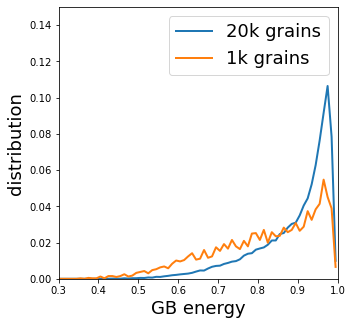

<Figure size 432x288 with 0 Axes>

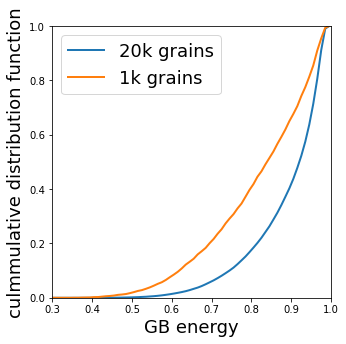

In [7]:
    # distribution for init and end
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2
    
    figure_name_distri = f"figures/3D_one_step_distribution_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin_first/np.sum(GBenergy_bin_first),'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, GBenergy_bin_second/np.sum(GBenergy_bin_second),'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')
    
    # distribution for init and end
    figure_name_distri = f"figures/3D_culmmulative_distribution_function_{case_name}.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    first_step = 0
    second_step = step_1000grains
    GBenergy_bin_first = np.zeros(bin_number)
    for index in range(len(GB_list_GBenergy_list[first_step])):
        if abs(GB_list_GBenergy_list[first_step][index])>=1.0: continue
        GBenergy_bin_first[int((GB_list_GBenergy_list[first_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_first = GBenergy_bin_first/np.sum(GBenergy_bin_first)
    for index in range(len(GB_list_GBenergy_list[second_step])):
        if abs(GB_list_GBenergy_list[second_step][index])>=1.0: continue
        GBenergy_bin_second[int((GB_list_GBenergy_list[second_step][index]-x_lim[0])//bin_interval)] += 1
    GBenergy_bin_second = GBenergy_bin_second/np.sum(GBenergy_bin_second)
    culmmulative_GBenergy_bin_first = np.zeros(bin_number) 
    culmmulative_GBenergy_bin_second = np.zeros(bin_number) 
    for i in range(bin_number):
        culmmulative_GBenergy_bin_first[i] = np.sum(GBenergy_bin_first[:i+1])
        culmmulative_GBenergy_bin_second[i] = np.sum(GBenergy_bin_second[:i+1])
    plt.xlim([0.3,1.0])
    plt.ylim([0,1.0])
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_first,'-', linewidth=2,label="20k grains")
    plt.plot(GBenergy_coordinate, culmmulative_GBenergy_bin_second,'-', linewidth=2,label=f"1k grains")
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("culmmulative distribution function", fontsize=18)
    plt.savefig(figure_name_distri, dpi=400,bbox_inches='tight')


## For one time step

In [21]:
 
    expected_grain_num = 5000
    
    # get corresponding step
    grain_num_array = np.zeros(npy_file_aniso.shape[0])
    for time_step in tqdm(range(npy_file_aniso.shape[0])):
        # Calculate the number of grains
        unique_id_num = len(np.unique(npy_file_aniso[time_step,:]))
        grain_num_array[time_step] = unique_id_num
        if unique_id_num < expected_grain_num*0.9: break # jump out of the loop if the id is too less
    expected_step = int(np.argmin(abs(grain_num_array - expected_grain_num)))
    

 27%|██▋       | 15/56 [00:37<01:43,  2.51s/it]


In [22]:
    # fraction
    total_GB_num_1step = len(GB_infomation_dict_list[expected_step].keys())
    anti_c_num_1step = 0
    for key in GB_id_focus_detail:
        if expected_step in GB_id_focus_detail[key]: anti_c_num_1step += 1
    print(f"Anti-curvature GBs at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step}")
    print(f"Anti-curvature fraction at step {expected_step} with {expected_grain_num} grains is {anti_c_num_1step/total_GB_num_1step*100}% in {total_GB_num_1step} GBs")



Anti-curvature GBs at step 13 with 5000 grains is 11931
Anti-curvature fraction at step 13 with 5000 grains is 35.004694284708364% in 34084 GBs


<Figure size 432x288 with 0 Axes>

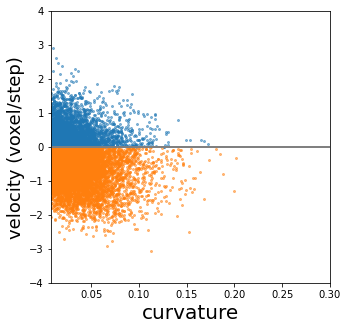

<Figure size 432x288 with 0 Axes>

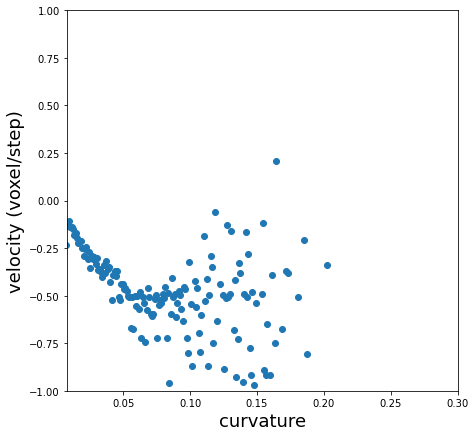

In [23]:
    # All in 1 figrue
    curvature_1Dlist_1step = GB_list_curvature_list[expected_step]
    velocity_1Dlist_1step = GB_list_velocity_list[expected_step]
    GBenergy_1Dlist_1step = GB_list_GBenergy_list[expected_step]
    GB_antic_list_curvature_1step = GB_antic_list_curvature_AllList[expected_step]
    GB_antic_list_velocity_1step = GB_antic_list_velocity_AllList[expected_step]
    GB_antic_list_GBenergy_1step = GB_antic_list_GBenergy_AllList[expected_step]
    GB_antic_list_anticNum_1step = GB_antic_list_anticNum_AllList[expected_step]
    
    # ignore the sign of curvature for all GBs list
    for i in range(len(curvature_1Dlist_1step)):
        if curvature_1Dlist_1step[i]<0: 
            curvature_1Dlist_1step[i] = - curvature_1Dlist_1step[i]
            velocity_1Dlist_1step[i] = - velocity_1Dlist_1step[i]
    velocity_1Dlist_1step = np.array(velocity_1Dlist_1step)
    curvature_1Dlist_1step = np.array(curvature_1Dlist_1step)
            
    figure_name_all = f"figures/3D_velocity_signedcurvature_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(5, 5))
    plt.plot([curvature_limit,0.3],[0,0],'-',color='grey',linewidth=2)
    plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step>0], velocity_1Dlist_1step[velocity_1Dlist_1step>0],s=4,alpha=0.5)
    # plt.scatter(curvature_1Dlist_1step[velocity_1Dlist_1step<0], velocity_1Dlist_1step[velocity_1Dlist_1step<0],s=4,alpha=0.5,color='C01')
    plt.scatter(GB_antic_list_curvature_1step, GB_antic_list_velocity_1step,s=4,alpha=0.5,color='C01')
    plt.xlabel("curvature", fontsize=20)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-4.0,4.0])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.3]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_1step)):
        if abs(curvature_1Dlist_1step[index])>x_lim[1]: continue
        curvature_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_signedcurvature_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([curvature_limit,0.3])
    plt.ylim([-1,1])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


0.27205923482024785


Text(0, 0.5, 'num of site')

<Figure size 432x288 with 0 Axes>

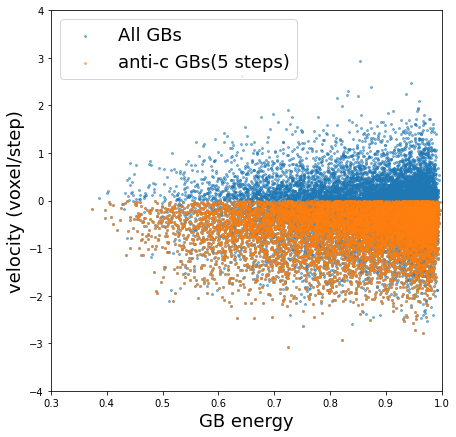

<Figure size 432x288 with 0 Axes>

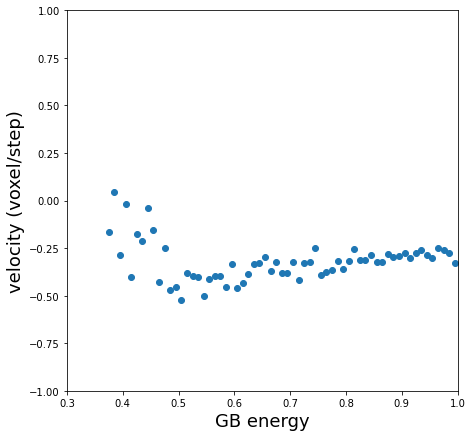

<Figure size 432x288 with 0 Axes>

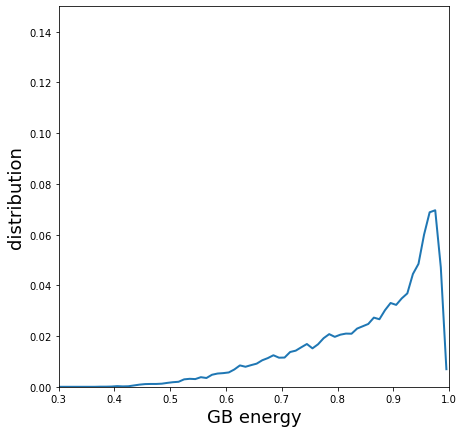

<Figure size 432x288 with 0 Axes>

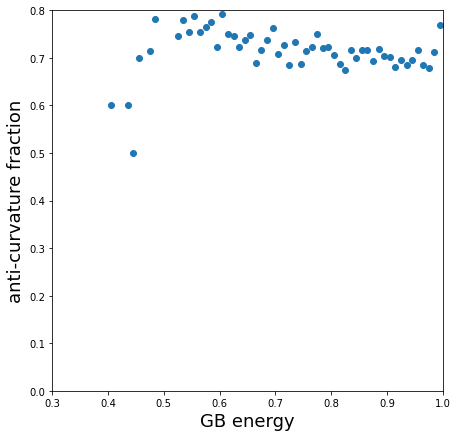

<Figure size 432x288 with 0 Axes>

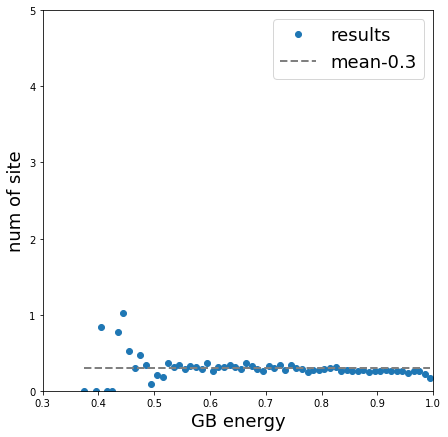

In [24]:

    figure_name_all = f"figures/3D_velocity_GBenergy_{case_name}_5d_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_1step, velocity_1Dlist_1step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_1step = np.array(GB_antic_list_GBenergy_1step)
    GB_antic_list_velocity_1step = np.array(GB_antic_list_velocity_1step)
    GB_antic_list_anticNum_1step = np.array(GB_antic_list_anticNum_1step)
    plt.scatter(GB_antic_list_GBenergy_1step[GB_antic_list_anticNum_1step>=5], GB_antic_list_velocity_1step[GB_antic_list_anticNum_1step>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-4,4])
    plt.legend(fontsize=18)
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_1step)):
        if abs(GBenergy_1Dlist_1step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_1step[index]
        if velocity_1Dlist_1step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_1step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_1step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/3D_velocity_GBenergy_{case_name}_5d_afterBin_{expected_grain_num}grains.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-1,1])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.8])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-curvature fraction", fontsize=18)
    
    anti_c_data_file_name = f"data/3D_antic_data_{case_name}_{expected_grain_num}grains"
    np.savez(anti_c_data_file_name,antic_ratio_bin=antic_ratio_bin,GBenergy_bin=GBenergy_bin)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    mean_delta_n_2 = np.sum(delta_n*GBenergy_bin[antic_ratio_bin>0]/np.sum(GBenergy_bin[antic_ratio_bin>0]))
    print(mean_delta_n_2)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


## 2D case

In [ ]:
if __name__ == '__main__':
    # File name
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "M_20k_fully"
    npy_file_name_aniso = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    npy_file_name_aniso_energy = f"p_aveE_fz_fully5d_20k_J1_f1.0_t0.0_refer_1_0_0_seed56689_kt0.66_energy.npy"
    # npy_file_name_aniso_energy = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66_energy.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso) # microstructure
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    npy_file_aniso_energy = np.load(npy_file_folder + npy_file_name_aniso_energy) # energy
    print(f"The {case_name} data size is: {npy_file_aniso_energy.shape}")
    print("READING ENERGY DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape

In [ ]:
    # GB information
    step_num=121
    grain_nums = 20000
    GB_infomation_dict_list = []
    curvature_matrix_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_signedcurvature_velocity_data_{case_name}_step{time_step}.npz"
        data_curvature_file_name = f"GB_velocity_data/2D_matrix_signedcurvature_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            # get curvature with sign
            if os.path.exists(data_file_folder + data_curvature_file_name):
                npz_file_curvature = np.load(data_file_folder + data_curvature_file_name)
                curvature_matrix = npz_file_curvature["curvature_matrix"]
                curvature_matrix_list.append(curvature_matrix)
            else:
                cores = 128
                loop_times = 5
                R = np.zeros((size_x,size_y,3))
                smoothing_class = linear2d.linear_class(size_x,size_y,grain_nums,cores,loop_times,current_microstructure[:,:,0],R,verification_system = False,curvature_sign = True)
                smoothing_class.linear_main("curvature")
                C_ln = smoothing_class.get_C()
                curvature_matrix = C_ln[1,:]
                curvature_matrix_list.append(curvature_matrix)
                # save curvature information
                # np.savez(data_file_folder + data_curvature_file_name, curvature_matrix=curvature_matrix)
            print("Finish curvature calculation")
            
            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")
            
            # Get the center of each GB
            GB_infomation_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GB_infomation_dict:
                        GB_infomation_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-curvature,i,j,k,curvature,GBnum,gid0,gid1
                        GB_infomation_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GB_infomation_dict:
                    GB_infomation_dict[pair_id][0] += 1
                    if central_site == pair_id_pair[0]:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,curvature_matrix[i,j]])
                    else:
                        GB_infomation_dict[pair_id][1:5] += np.array([i,j,k,-curvature_matrix[i,j]])
                    
            # get the correct location for each GB
            small_GB_list = []
            for key in GB_infomation_dict: 
                if GB_infomation_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GB_infomation_dict.pop(small_GB_list[s_index])
            for key in GB_infomation_dict: 
                GB_infomation_dict[key][1:5]=GB_infomation_dict[key][1:5]/GB_infomation_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GB_infomation_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name, GB_infomation_dict=GB_infomation_dict)
            GB_infomation_dict_list.append(GB_infomation_dict)

In [ ]:
    # GB Energy information
    step_num=121
    grain_nums = 20000
    GBenergy_information_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name_GBenergy = f"GB_velocity_data/2D_GBenergy_velocity_data_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name_GBenergy):
            npz_file = np.load(data_file_folder + data_file_name_GBenergy,allow_pickle=True)
            GBenergy_information_dict = npz_file["GBenergy_information_dict"]
            GBenergy_information_dict_list.append(GBenergy_information_dict.item())
        else:
            current_microstructure = npy_file_aniso[time_step]
            current_energy = npy_file_aniso_energy[time_step]

            # Get TJ and QJ information first
            TJ_infomation_dict = dict()
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: 
                        for m in range(len(neighboring_sites_list_unque)):
                            pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[m]) # get pair id
                            if pair_id in TJ_infomation_dict:
                                tmp = TJ_infomation_dict[pair_id]
                                tmp.append([i,j,k])
                                TJ_infomation_dict[pair_id] = tmp
                            else: 
                                TJ_infomation_dict[pair_id] = [[i,j,k]]
            print("Finish TJ extraction")

            # Get the center of each GB
            GBenergy_information_dict = dict()
            TJ_distance_max = 6 # voxels
            for index, result in np.ndenumerate(current_microstructure):
                i,j,k = index
                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                if ( ((current_microstructure[ip,j,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[im,j,k]-current_microstructure[i,j,k])!=0) or\
                     ((current_microstructure[i,jp,k]-current_microstructure[i,j,k])!=0) or ((current_microstructure[i,jm,k]-current_microstructure[i,j,k])!=0) ):
                    central_site = int(current_microstructure[i,j,k])
                    neighboring_sites_list = np.array([current_microstructure[ip,j,k], current_microstructure[i,jp,k], current_microstructure[im,j,k], current_microstructure[i,jm,k]]).astype(int)
                    neighboring_sites_set = set(neighboring_sites_list) # Get all unique neighboring sites
                    if central_site in neighboring_sites_set: neighboring_sites_set.remove(central_site) # remove central site
                    neighboring_sites_list_unque = list(neighboring_sites_set)
                    num_other_sites = 0
                    neighboring_sites_full_list = np.array([current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                    for neigh_site in neighboring_sites_full_list:
                        if neigh_site != central_site: num_other_sites += 1 # get the sites num different with central id
                    # remove the TJs and QJs
                    if len(neighboring_sites_list_unque) > 1: continue # only remove TJs and QJs
                    # CONTINUE...    # remove the voxels around TJs and QJs
                    # check the GB voxels is close to TJ or not
                    break_point = 0
                    pair_id = post_processing.get_line(central_site, neighboring_sites_list_unque[0]) # get pair id
                    if central_site<neighboring_sites_list_unque[0]: pair_id_pair = [central_site, neighboring_sites_list_unque[0]]
                    else: pair_id_pair = [neighboring_sites_list_unque[0], central_site]
                    if pair_id in GBenergy_information_dict:
                        GBenergy_information_dict[pair_id][5] += 1 # GB area
                    else:
                        GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]]) # GBnum-energy,i,j,k,GB energy,GBnum,gid0,gid1
                        GBenergy_information_dict[pair_id] = GB_infomation
                    if pair_id in TJ_infomation_dict:
                        for TJ_site in TJ_infomation_dict[pair_id]:
                            TJ_distance = np.linalg.norm(index-np.array(TJ_site))
                            if TJ_distance < TJ_distance_max: 
                                break_point = 1
                                break
                    if break_point == 1: continue
                    # calculate or extract misorientation
                    # if pair_id in GBenergy_information_dict:
                    GBenergy_information_dict[pair_id][0] += 1
                    GBenergy_information_dict[pair_id][1:5] += np.array([i,j,k,current_energy[i,j,k]/num_other_sites])

            # get the correct location for each GB
            small_GB_list = []
            for key in GBenergy_information_dict: 
                if GBenergy_information_dict[key][0] == 0: 
                    small_GB_list.append(key) # remove the small GB with 0 voxels after remove voxels close to TJs
            for s_index in range(len(small_GB_list)): GBenergy_information_dict.pop(small_GB_list[s_index])
            for key in GBenergy_information_dict: 
                GBenergy_information_dict[key][1:5]=GBenergy_information_dict[key][1:5]/GBenergy_information_dict[key][0]
            print(f"Current GBs len at {time_step} steps: {len(GBenergy_information_dict)}")
            # save information
            np.savez(data_file_folder + data_file_name_GBenergy, GBenergy_information_dict=GBenergy_information_dict)
            GBenergy_information_dict_list.append(GBenergy_information_dict)

In [ ]:
    time_interval = 30
    # store all GB points, include curvature and anti-curvature(include randomness points)
    GB_list_velocity_list = []
    GB_list_curvature_list = []
    GB_list_GBenergy_list = []
    # store all GB point exclude anti-curvature randomness points
    GB_list_velocity_list_exrandom = []
    GB_list_curvature_list_exrandom = []
    # store GB energy point exclude anti_c randomness points
    GB_list_GBenergy_list_exrandom = []
    # store anti-curvature GBs in dictionary
    GB_id_focus = dict()
    GB_id_focus_detail = dict()
    GB_filter_kernel = [set(),set(),set(),set(),set()]
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_curvature_list_tmp = []
        GB_list_GBenergy_list_tmp = []
        GB_list_velocity_list_exrandom_tmp = []
        GB_list_curvature_list_exrandom_tmp = []
        GB_list_GBenergy_list_exrandom_tmp = []
        key_set = set()
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            if GB_infomation_dict_list[time_step][key][5] < 100: continue # remove small GBs
            # if abs(GB_infomation_dict_list[time_step][key][4]) < 0.0125: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step][key][4]
            GB_list_curvature_list_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_tmp.append(GBenergy_information_dict_list[time_step][key][4])
            
            # keep anti-curvature GB info
            if current_curvature_value*velocity<-0.0001: 
                key_set.add(key)
                if time_step >= step_num-3: continue
                if key in GB_id_focus: 
                    GB_id_focus[key] += 1
                    GB_id_focus_detail[key].append(time_step)
                else: 
                    GB_id_focus[key] = 1
                    GB_id_focus_detail[key] = [time_step]
        
        # keep all GBs with GB length larger than 100
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_curvature_list.append(GB_list_curvature_list_tmp)
        GB_list_GBenergy_list.append(GB_list_GBenergy_list_tmp)
        
        # filter the anti-curvature GB with 00100
        GB_filter_kernel[0:4] = GB_filter_kernel[1:]
        GB_filter_kernel[4] = key_set
        filtered_set = GB_filter_kernel[2] - (GB_filter_kernel[0]|GB_filter_kernel[1]|GB_filter_kernel[3]|GB_filter_kernel[4])
        for key in filtered_set: 
            GB_id_focus[key] -= 1
            GB_id_focus_detail[key].remove(time_step-2)
        print(f"finish {time_step} with num of GBs {len(GB_list_velocity_list_tmp)}, and collected num of GBs {len(GB_id_focus)}")
        
        # remove exclude data
        if time_step < 2: continue
        for key in tqdm(GB_infomation_dict_list[time_step-2]):
            if GB_infomation_dict_list[time_step-1].get(key) is None: continue
            if GB_infomation_dict_list[time_step-2][key][5] < 100: continue # remove small GBs
            if key in filtered_set: continue # remove the randomness points
            # if abs(GB_infomation_dict_list[time_step-2][key][4]) < 0.0125: continue # remove low curvature
            # Calculate dV
            pair_id_pair = GB_infomation_dict_list[time_step-2][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step-2]==pair_id_pair[0])*(npy_file_aniso[time_step-1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step-2]==pair_id_pair[1])*(npy_file_aniso[time_step-1]==pair_id_pair[0])
            dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
            # calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step-2][key][5]/2)
            GB_list_velocity_list_exrandom_tmp.append(velocity)
            # keep curvature
            current_curvature_value = GB_infomation_dict_list[time_step-2][key][4]
            GB_list_curvature_list_exrandom_tmp.append(current_curvature_value)
            # keep GB energy
            GB_list_GBenergy_list_exrandom_tmp.append(GBenergy_information_dict_list[time_step-2][key][4])
        GB_list_velocity_list_exrandom.append(GB_list_velocity_list_exrandom_tmp)
        GB_list_curvature_list_exrandom.append(GB_list_curvature_list_exrandom_tmp)
        GB_list_GBenergy_list_exrandom.append(GB_list_GBenergy_list_exrandom_tmp)
        
    
    # filter the anti-curvature GB with 00100
    GB_id_focus_copy = GB_id_focus.copy()
    for key in GB_id_focus_copy:
        if GB_id_focus_copy[key] <=0:
            GB_id_focus.pop(key)
            GB_id_focus_detail.pop(key)
            
    # add the last two steps for exclude data
    # GB_list_velocity_list_exrandom.extend(GB_list_velocity_list[-2:])
    # GB_list_curvature_list_exrandom.extend(GB_list_curvature_list[-2:])
    # GB_list_GBenergy_list_exrandom.extend(GB_list_GBenergy_list[-2:])
            

In [ ]:
    time_interval = 30
    # GB_list_velocity_list = []
    GB_antic_list_velocity_list = []
    GB_antic_list_GBenergy_list = []
    GB_antic_list_anticNum_list = []
    GB_id_unfocus_lowE_detail = dict()
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        for key in tqdm(GBenergy_information_dict_list[time_step]):
            if GBenergy_information_dict_list[time_step+1].get(key) is None: continue
            if GBenergy_information_dict_list[time_step][key][5] < 100: continue # remove small GBs
            # if abs(GB_infomation_dict_list[time_step][key][4]) < 0.0125: continue # remove low curvature
            
            # keep the GB with low energy and curvature behavior
            if (GBenergy_information_dict_list[time_step][key][4]<0.4) and (key not in GB_id_focus_detail): # do we need to remove random here?
                if key in GB_id_unfocus_lowE_detail:
                    GB_id_unfocus_lowE_detail[key].append(time_step)
                else:
                    GB_id_unfocus_lowE_detail[key] = [time_step]
            
            # anti-curvature behavior list
            if (key in GB_id_focus_detail) and (time_step in GB_id_focus_detail[key]):
                # Calculate dV
                pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
                growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
                growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
                dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
                # calculate velocity
                velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
                # correct the sign of velocity
                current_curvature_value = GB_infomation_dict_list[time_step][key][4]
                if current_curvature_value < 0: GB_antic_list_velocity_list.append(-velocity)
                else: GB_antic_list_velocity_list.append(velocity)
                
                GB_antic_list_GBenergy_list.append(GBenergy_information_dict_list[time_step][key][4])
                GB_antic_list_anticNum_list.append(GB_id_focus[key])
            
        
            

In [ ]:
    total_GB = set()
    for time_step in range(step_num):
        step_GB = GB_infomation_dict_list[time_step].keys()
        total_GB = total_GB | step_GB

    print(f"The number of the GBs showing anti-curvature during whole simulations is {len(GB_id_focus.values())}")
    print(f"The ratio of anti-curvature GBs during whole simulations is {len(GB_id_focus.values())/len(total_GB)*100}% in {len(total_GB)} GBs")
    print(GB_id_focus.values())

In [ ]:
    # All in 1 figrue
    curvature_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    GBenergy_1Dlist_remove_0step = []
    for i in range(0,len(GB_list_velocity_list)): 
        curvature_1Dlist_remove_0step.extend(GB_list_curvature_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
        GBenergy_1Dlist_remove_0step.extend(GB_list_GBenergy_list[i])
    curvature_1Dlist_exrandom_remove_0step = []
    velocity_1Dlist_exrandom_remove_0step = []
    GBenergy_1Dlist_exrandom_remove_0step = []
    for i in range(0,len(GB_list_velocity_list_exrandom)): 
        curvature_1Dlist_exrandom_remove_0step.extend(GB_list_curvature_list_exrandom[i])
        velocity_1Dlist_exrandom_remove_0step.extend(GB_list_velocity_list_exrandom[i])
        GBenergy_1Dlist_exrandom_remove_0step.extend(GB_list_GBenergy_list_exrandom[i])
    
    # ignore the sign of curvature
    for i in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if curvature_1Dlist_exrandom_remove_0step[i]<0: 
            curvature_1Dlist_exrandom_remove_0step[i] = - curvature_1Dlist_exrandom_remove_0step[i]
            velocity_1Dlist_exrandom_remove_0step[i] = - velocity_1Dlist_exrandom_remove_0step[i]
            
    figure_name_all = f"figures/2D_velocity_signedcurvature_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(curvature_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.0,0.1])
    plt.ylim([-0.6,0.6])
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged curvature
    bin_interval = 0.001
    x_lim = [0.0,0.1]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    curvature_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    curvature_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(curvature_1Dlist_exrandom_remove_0step)):
        if abs(curvature_1Dlist_exrandom_remove_0step[index])>0.1: continue
        curvature_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((curvature_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
    for i in range(bin_number): 
        if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_signedcurvature_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.0,0.1])
    plt.ylim([-0.2,0.2])
    plt.plot(curvature_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("curvature", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


In [ ]:

    figure_name_all = f"figures/2D_velocity_GBenergy_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(GBenergy_1Dlist_exrandom_remove_0step, velocity_1Dlist_exrandom_remove_0step,s=4,alpha=0.5,label='All GBs')
    GB_antic_list_GBenergy_list = np.array(GB_antic_list_GBenergy_list)
    GB_antic_list_velocity_list = np.array(GB_antic_list_velocity_list)
    GB_antic_list_anticNum_array = np.array(GB_antic_list_anticNum_list)
    plt.scatter(GB_antic_list_GBenergy_list[GB_antic_list_anticNum_array>=5], GB_antic_list_velocity_list[GB_antic_list_anticNum_array>=5],s=4,alpha=0.5,label='anti-c GBs(5 steps)')
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.6,0.6])
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged GBenergy
    bin_interval = 0.01
    x_lim = [0.25,1.0]
    bin_number = int((x_lim[1]-x_lim[0])/bin_interval)
    GBenergy_coordinate = np.arange(x_lim[0],x_lim[1],bin_interval)+bin_interval/2

    GBenergy_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    antic_num_bin = np.zeros(bin_number)
    for index in range(len(GBenergy_1Dlist_exrandom_remove_0step)):
        if abs(GBenergy_1Dlist_exrandom_remove_0step[index])>=1.0: continue
        GBenergy_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        velocity_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += velocity_1Dlist_exrandom_remove_0step[index]
        if velocity_1Dlist_exrandom_remove_0step[index] < 0: antic_num_bin[int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)] += 1
        if int((GBenergy_1Dlist_exrandom_remove_0step[index]-x_lim[0])//bin_interval)<0: print(GBenergy_1Dlist_exrandom_remove_0step[index])
    for i in range(bin_number): 
        if GBenergy_bin[i]>0: velocity_bin[i] = velocity_bin[i]/GBenergy_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_GBenergy_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    # plt.scatter(GBenergy_coordinate, velocity_bin,s=4,alpha=0.5)
    plt.xlim([0.3,1.0])
    plt.ylim([-0.2,0.2])
    plt.plot(GBenergy_coordinate[velocity_bin!=0], velocity_bin[velocity_bin!=0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
    
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.15])
    plt.plot(GBenergy_coordinate, GBenergy_bin/np.sum(GBenergy_bin),'-', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("distribution", fontsize=18)
    
    antic_ratio_bin = np.zeros(bin_number)
    for bin_i in range(len(GBenergy_bin)):
        if GBenergy_bin[bin_i] > 0: antic_ratio_bin[bin_i] = antic_num_bin[bin_i]/GBenergy_bin[bin_i]
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,0.5])
    plt.plot(GBenergy_coordinate[antic_ratio_bin>0], antic_ratio_bin[antic_ratio_bin>0],'o', linewidth=2)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("anti-c ratio", fontsize=18)
    
    GBenergy_coordinate_larger0 = GBenergy_coordinate[antic_ratio_bin>0]
    delta_n = -0.66*np.log(antic_ratio_bin[antic_ratio_bin>0])/GBenergy_coordinate[antic_ratio_bin>0]
    mean_delta_n = np.mean(delta_n)
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.xlim([0.3,1.0])
    plt.ylim([0,5])
    plt.plot(GBenergy_coordinate_larger0, delta_n,'o', linewidth=2, label = 'results')
    plt.plot(GBenergy_coordinate_larger0, mean_delta_n*np.ones(len(GBenergy_coordinate_larger0)),'--',linewidth=2,color='gray',label=f'mean-{round(mean_delta_n,2)}')
    plt.legend(fontsize=18)
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("num of site", fontsize=18)
        


In [ ]:
    # Plot relationship for each time steps
    for time_step in range(0,len(GB_list_velocity_list),10):
        figure_name = f"figures/2D_velocity_signedcurvature_MI_step{time_step}_{case_name}.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        plt.scatter(GB_list_curvature_list[time_step], GB_list_velocity_list[time_step],s=4,alpha=0.5)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-10,10])
        # plt.savefig(figure_name, dpi=400,bbox_inches='tight')
        
        # plot velocity VS averaged curvature
        bin_interval = 0.001
        bin_number = int(1.2/bin_interval)
        curvature_coordinate = np.arange(-0.6,0.6,bin_interval)+bin_interval/2

        curvature_bin = np.zeros(bin_number)
        velocity_bin = np.zeros(bin_number)
        for index in range(len(GB_list_curvature_list[time_step])):
            if abs(GB_list_curvature_list[time_step][index])>0.6: continue
            curvature_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += 1
            velocity_bin[int((GB_list_curvature_list[time_step][index]+0.6)//bin_interval)] += GB_list_velocity_list[time_step][index]
        for i in range(bin_number): 
            if curvature_bin[i]>0: velocity_bin[i] = velocity_bin[i]/curvature_bin[i]
        # plot
        figure_name_all_bin = f"figures/2D_velocity_signedcurvature_step{time_step}_{case_name}_afterBin.png"
        plt.figure()
        fig = plt.figure(figsize=(7, 7))
        # plt.scatter(curvature_coordinate, velocity_bin,s=4,alpha=0.5)
        plt.plot(curvature_coordinate, velocity_bin,'o', linewidth=2)
        plt.xlabel("curvature", fontsize=18)
        plt.ylabel("velocity (voxel/step)", fontsize=18)
        plt.xlim([-0.6,0.6])
        plt.ylim([-5,5])
        # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')

In [ ]:
# Get more information for a focus GB

key_focus = 0
for key in GB_id_focus:
    if GB_id_focus[key] == 19: 
        print(f"The longest anti-curvature behavior is {key} with steps {GB_id_focus[key]}")
        key_focus = key
        # break

v_focus = []
c_focus = []
for time_step in range(0,step_num):
    if key_focus in GB_infomation_dict_list[time_step]:
        # Calculate dV
        pair_id_pair_focus = GB_infomation_dict_list[time_step][key_focus][6:8]
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key_focus][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
        
        # make curvature always opposite
        if current_curvature_value<0: 
            current_curvature_value = -current_curvature_value
            velocity = -velocity
        
        # store v-c for a focus GB
        v_focus.append(velocity)
        c_focus.append(current_curvature_value)
        
        if current_curvature_value*velocity<-0.00 and GB_infomation_dict_list[time_step][key_focus][5]>=100: 
            print(f"The anti-curvature step {time_step} has velocity - {round(velocity,3)} and curvature - {round(current_curvature_value,3)}.")
        
        

v_focus = np.array(v_focus)
c_focus = np.array(c_focus)
# plot v-c for a focus GB
wanted_steps = v_focus<0
alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))

figure_name_one_GB = f"figures/2D_velocity_signedcurvature_{case_name}_GB{key_focus}_5d.png"
plt.figure()
fig = plt.figure(figsize=(7, 7))
import matplotlib as mpl
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0, 1, 20))
plt.scatter(c_focus[wanted_steps], v_focus[wanted_steps],s=8,alpha=alpha_list,color=colors[0])
plt.scatter(c_focus[~wanted_steps], v_focus[~wanted_steps],s=8,alpha=0.2,color=colors[6])
plt.plot(c_focus,v_focus,alpha=0.1)
plt.xlabel("curvature", fontsize=18)
plt.ylabel("velocity (voxel/step)", fontsize=18)
plt.xlim([0,0.17])
plt.ylim([-0.2,0.2])
plt.legend(["anti-c", "c", "sequence"],fontsize=18)
plt.title(f"GBid {key_focus} step all")
# plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')






In [ ]:
import os
os.system(f'ffmpeg -framerate 10 -i /home/lin.yang/projects/VECTOR/examples/GB_velocity/anti_curvature_figures/Detail_2D_microstructure_key145919744_step.%04d._M_20k.png \
                    -c:v libx264 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p \
                    anti_curvature_figures/Detail_2D_microstructure_key145919744_M_20k.mp4')

In [ ]:
# 197673737
# 47836998
# fully 88634987
# fully 161070774
# fully 30685022
# Find the exaxt grain id and time steps
GB_id = 145919744
for time_step in range(40,step_num):
    if GB_id not in GB_infomation_dict_list[time_step]: continue
    pair_id_pair_focus = GB_infomation_dict_list[time_step][GB_id][6:8]
    break
print(f"The id pairs are {list(map(int,pair_id_pair_focus))}")

time_step_init, time_step_end = 24, 100
check_edge = 0
ss = 0
for time_step in tqdm(range(time_step_init,time_step_end)):
    current_microstructure_focus = npy_file_aniso[time_step,:,:,0]
    grain_location_focus = (current_microstructure_focus==pair_id_pair_focus[0]) + (current_microstructure_focus==pair_id_pair_focus[1])
    if check_edge ==0:
        x_info = np.arange(0,2400,1)[np.sum(grain_location_focus,0)*np.arange(0,2400,1)>0]
        x_len = np.sum(x_info>0)
        x_lim_max = int(np.max(x_info)+(x_len/2))
        x_lim_min = int(np.min(x_info)-(x_len/2))
        y_info = np.arange(0,2400,1)[np.sum(grain_location_focus,1)*np.arange(0,2400,1)>0]
        y_len = np.sum(y_info>0)
        y_lim_max = int(np.max(y_info)+y_len/2)
        y_lim_min = int(np.min(y_info)-y_len/2)
        check_edge+=1
    if np.sum(grain_location_focus)==0: continue
    current_microstructure_focus_updated = current_microstructure_focus*grain_location_focus
    
    if GB_id in GB_infomation_dict_list[time_step]:
        # Calculate velocity
        growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
        growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
        dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
        # Calculate velocity
        velocity = dV/time_interval/(GB_infomation_dict_list[time_step][GB_id][5]/2)
        current_curvature_value = GB_infomation_dict_list[time_step][GB_id][4]
    else:
        velocity = 0
        current_curvature_value = 0
    
    if ss<10:
        ss_char = f'0{ss}'
    else:
        ss_char = f'{ss}'
    ss+=1
    figure_name_anti_curvature_detail = figure_name_anti_curvature = f"anti_curvature_figures/Detail_2D_microstructure_key{GB_id}_step.00{ss_char}._{case_name}.png"
    plt.figure(figsize=(7,7))
    plt.imshow(current_microstructure_focus_updated,vmin=0,vmax=20000)
    plt.xlim([x_lim_min, x_lim_max])
    plt.ylim([y_lim_max, y_lim_min])
    if round(velocity,2)*round(current_curvature_value,3)<0:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", color='orange', fontsize=16)
    else:
        plt.title(rf"v: {round(velocity,2)} $\kappa$: {round(current_curvature_value,3)} at step {time_step}", fontsize=16)
    # plt.axis("off")
    # plt.savefig(figure_name_anti_curvature_detail, dpi=400,bbox_inches='tight')

In [ ]:

def energy_function_m_axis(m_polar_angle, m_azimuth_angle):
    return abs(np.cos(m_azimuth_angle)) * m_polar_angle / np.pi

def energy_function_m_axis_new(m_polar_angle, m_azimuth_angle):
    # ss = abs(np.cos(m_azimuth_angle/2)) + abs(np.cos(m_polar_angle))
    
    ss = (abs(np.cos(m_azimuth_angle/2))**0.4 + abs(np.cos(m_polar_angle))**0.4)
    if ss > 1: return 1
    else: return ss
    
    # if abs(m_azimuth_angle-np.pi) < np.pi/18 and abs(m_polar_angle - np.pi/2) < np.pi/36: return 0.0
    # else: return 1.0
    
    # return (abs(np.cos(m_azimuth_angle/2))**1.0 + abs(np.cos(m_polar_angle))**1.0)

def energy_function_m(m_polar_angle, m_azimuth_angle, m_angle):
    max_m_angle = 10/180*np.pi
    if m_angle == 0: return 0
    if m_angle>max_m_angle: m_angle=max_m_angle-0.00001
    m_angle_impact = m_angle/max_m_angle*(1-np.log(m_angle/max_m_angle))
    return energy_function_m_axis_new(m_polar_angle, m_azimuth_angle)*m_angle_impact

def energy_function_i_axis(i_polar_angle, i_azimuth_angle):
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7 + i_polar_angle / (np.pi/2) * (0.3 - 0.7))

def energy_function_final(m_polar_angle, m_azimuth_angle, m_angle, i_polar_angle, i_azimuth_angle):
    
    if i_polar_angle>np.pi/2: i_polar_angle = np.pi-i_polar_angle
    m_energy_impact = energy_function_m(m_polar_angle, m_azimuth_angle, m_angle)
    return 0.3 + abs(np.cos(i_azimuth_angle)) * (0.7*m_energy_impact + i_polar_angle / (np.pi/2) * (0.3*m_energy_impact - 0.7*m_energy_impact))


def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [ ]:
# # Plot more information for a focus GB

# # Misorientation
# init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
# init_file_name = f"Case4.init"
# # misorientation calculation preparation
# grain_nums = 20000
# Osym = 24
# symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
# print("> Pre-work done")

# misorientation = post_processing.multiP_calM(list(map(int,pair_id_pair_focus)), quartAngle, symm2quat_matrix, Osym)
# misorientation_angle = misorientation[0] # miso angle in randians
# misorientation_axis = misorientation[1:]

# # misorientation energy
# m_polar_angle = math.acos(round(misorientation_axis[2],3))
# m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
# print(f"The m-angle: {misorientation_angle/np.pi*180}, m_polar_angle: {m_polar_angle/np.pi*180}, m_azimuth_angle: {m_azimuth_angle/np.pi*180}")
# print(f"The misorientation energy: {energy_function_m(m_polar_angle, m_azimuth_angle, misorientation_angle)}")



In [ ]:
# # inclination
# GB_infomation_inc_dict_list = []
# for time_step in tqdm(range(step_num)):
#     data_file_name = f"GB_velocity_data/2D_inclination_velocity_data_{case_name}_step{time_step}.npz"
#     if os.path.exists(data_file_folder + data_file_name):
#         npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
#         GB_infomation_inc_dict = npz_file["GB_infomation_dict"]
#         GB_infomation_inc_dict_list.append(GB_infomation_inc_dict.item())
#     else:
#         print(f"Please run inclination-velocity analysis for {case_name}")
#         break

# time_interval = 30
# GB_inclination_energy_list = []
# GB_final_energy_list = []
# GB_velocity_list = []
# for time_step in range(step_num):
#     if time_step+1 >= step_num: continue
#     if key_focus not in GB_infomation_inc_dict_list[time_step]: continue
#     if GB_infomation_inc_dict_list[time_step+1].get(key_focus) is None: continue
#     # Calculate volumn change
#     growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair_focus[0])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[1])
#     growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair_focus[1])*(npy_file_aniso[time_step+1]==pair_id_pair_focus[0])
#     dV = np.sum(growth_direction1)-np.sum(growth_direction2) # velocity with direction
#     # Calculate velocity
#     velocity = dV/time_interval/(GB_infomation_inc_dict_list[time_step][key_focus][6]/2)
#     # change velocity sign with curvature
#     current_curvature_value = GB_infomation_dict_list[time_step][key_focus][4]
#     # make curvature always opposite
#     if current_curvature_value<0: 
#         current_curvature_value = -current_curvature_value
#         velocity = -velocity
    
#     GB_velocity_list.append(velocity)

#     # Get inclination
#     DX, DY = GB_infomation_inc_dict_list[time_step][key_focus][4:6]
#     vec_len = np.sqrt(DX**2+DY**2)
#     if vec_len==0: dx, dy = 0, 0
#     else: dx, dy = -DX/vec_len, DY/vec_len # the process just repeated get_grad(P,i,j) in myInput.py 
#     dz = 0
#     dy = -dy # Update the issue in VECTOR
#     inclination = np.array([dx,dy,dz])
#     # Get misorientation
#     # rotate misorientation axis to z axis, and incliantion to final vector
#     z_axis = np.array([0,0,1])
#     rotation_matrix_m_axis_to_z_axis = rotation_matrix_from_vectors(misorientation_axis, z_axis)
#     incliantion_refer_m_axis = rotation_matrix_m_axis_to_z_axis.dot(inclination)
#     # Get polar and azimuth dsitribution
#     i_polar_angle = math.acos(round(incliantion_refer_m_axis[2],3))
#     i_azimuth_angle = math.atan2(incliantion_refer_m_axis[1], incliantion_refer_m_axis[0]) + np.pi
    
#     # inclination energy
#     inclination_energy = energy_function_i_axis(i_polar_angle, i_azimuth_angle)
#     final_energy = energy_function_final(m_polar_angle, m_azimuth_angle, misorientation_angle, i_polar_angle, i_azimuth_angle)
#     GB_inclination_energy_list.append(inclination_energy)
#     GB_final_energy_list.append(final_energy)
#     # print(inclination_energy)
#     # print(final_energy)
#     # print()




In [ ]:

# GB_inclination_energy_list = np.array(GB_inclination_energy_list)
# GB_velocity_list = np.array(GB_velocity_list)
# GB_final_energy_list = np.array(GB_final_energy_list)

# wanted_steps = GB_velocity_list<0
# alpha_list = np.linspace(0.2,1,np.sum(wanted_steps))
# figure_name_one_GB = f"figures/2D_velocity_inclinationE_{case_name}_GB{key_focus}_5d.png"
# plt.figure()
# fig = plt.figure(figsize=(7, 7))
# import matplotlib as mpl
# cmap = mpl.colormaps['tab20']
# colors = cmap(np.linspace(0, 1, 20))
# plt.scatter(GB_inclination_energy_list[wanted_steps], GB_velocity_list[wanted_steps],s=8,alpha=alpha_list,c=colors[0])
# plt.scatter(GB_inclination_energy_list[~wanted_steps], GB_velocity_list[~wanted_steps],s=8,alpha=0.2,c=colors[6])
# plt.plot(GB_inclination_energy_list,GB_velocity_list,alpha=0.1)
# plt.xlabel("inclination energy", fontsize=18)
# plt.ylabel("velocity (voxel/step)", fontsize=18)
# # plt.xlim([0.334,0.35])
# plt.ylim([-0.2,0.2])
# plt.legend(["anti-c", "c", "sequence"],fontsize=18)
# plt.title(f"GBid {key_focus} step all")
# # plt.savefig(figure_name_one_GB, dpi=400,bbox_inches='tight')

## TJ study


In [ ]:
    # GB_id_unfocus_lowE_detail and GB_id_focus_detail
    
    # reorginaize the data structure for GB_id_unfocus_lowE_detail and GB_id_focus_detail
    GB_id_unfocus_lowE_detail_time = dict()
    GB_id_focus_detail_time = dict()
    for key in GB_id_unfocus_lowE_detail:
        for key_time in GB_id_unfocus_lowE_detail[key]:
            if key_time in GB_id_unfocus_lowE_detail_time:
                GB_id_unfocus_lowE_detail_time[key_time].append(key)
            else: 
                GB_id_unfocus_lowE_detail_time[key_time] = [key]
                
    for key in GB_id_focus_detail:
        for key_time in GB_id_focus_detail[key]:
            if key_time in GB_id_focus_detail_time:
                GB_id_focus_detail_time[key_time].append(key)
            else:
                GB_id_focus_detail_time[key_time] = [key]
            
            
    # find the TJ around GB with anti-c behavior or low energy c behavior 
    site_energy_per_unit_focus_list = []
    site_energy_per_unit_unfocus_list = []
    for time_step in tqdm(range(step_num)):
        
        if time_step not in GB_id_focus_detail_time: current_focus_GB_id = []
        else: current_focus_GB_id = GB_id_focus_detail_time[time_step]
        if time_step not in GB_id_unfocus_lowE_detail_time: current_unfocus_GB_id = []
        else: current_unfocus_GB_id = GB_id_unfocus_lowE_detail_time[time_step]
        if len(current_focus_GB_id) == 0 and len(current_unfocus_GB_id) == 0: continue
        # current_GB_id = []
        # current_GB_id.extend(current_focus_GB_id)
        # current_GB_id.extend(current_unfocus_GB_id)
        current_microstructure = npy_file_aniso[time_step]
        current_energy = npy_file_aniso_energy[time_step]
        
        

        
        size_x, size_y = npy_file_aniso[time_step].shape[0:2]
        k=0
        for i in range(size_x):
            for j in range(size_y):

                ip,im,jp,jm = myInput.periodic_bc(size_x,size_y,i,j)
                # find window and jump over GB and grain bulk
                neighboring_sites_full_list = np.array([current_microstructure[i,j,k], current_microstructure[ip,jp,k], current_microstructure[ip,j,k], current_microstructure[ip,jm,k], current_microstructure[i,jp,k], current_microstructure[i,jm,k], current_microstructure[im,jp,k], current_microstructure[im,j,k], current_microstructure[im,jm,k]]).astype(int)
                grain_id_num_in_window = np.unique(neighboring_sites_full_list)
                if len(grain_id_num_in_window) < 3: continue
                
                # 
                do_you_find = 0
                for current_key in current_focus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_focus_list.append(site_energy/num_nei)
                        do_you_find += 1
                        break
                if do_you_find > 0: continue
                for current_key in current_unfocus_GB_id:
                    pair_id_pair_focus = GB_infomation_dict_list[time_step][current_key][6:8]
                    if pair_id_pair_focus[0] in grain_id_num_in_window and pair_id_pair_focus[0] in grain_id_num_in_window:
                        # do 
                        site_energy = current_energy[i,j,k]
                        num_nei = 0
                        for nei in neighboring_sites_full_list[1:]:
                            if neighboring_sites_full_list[0] != nei: num_nei += 1
                        site_energy_per_unit_unfocus_list.append(site_energy/num_nei)
                        break
                        
                
    xLim = [0,2.0]
    binValue = 0.01001
    binNum = round((abs(xLim[0])+abs(xLim[1]))/binValue)
    xCor = np.linspace((xLim[0]+binValue/2),(xLim[1]-binValue/2),binNum)
    freqArray_focus = np.zeros(binNum)
    freqArray_unfocus = np.zeros(binNum)

    for i in range(len(site_energy_per_unit_focus_list)): freqArray_focus[int((site_energy_per_unit_focus_list[i] - xCor[0]) / binValue)] += 1
    for i in range(len(site_energy_per_unit_unfocus_list)): freqArray_unfocus[int((site_energy_per_unit_unfocus_list[i] - xCor[0]) / binValue)] += 1
        
            
            
            

In [ ]:
    freqArray_focus = freqArray_focus/np.sum(freqArray_focus)
    freqArray_unfocus = freqArray_unfocus/np.sum(freqArray_unfocus)

    plt.figure(figsize=(7,7))
    plt.plot(xCor, freqArray_focus, label='anti-c')
    plt.plot(xCor, freqArray_unfocus, label='c')
    plt.xlim([0.25,1.05])
    # plt.ylim([-0.15,0.15])
    plt.xlabel("GB energy", fontsize=18)
    plt.ylabel("Frequency", fontsize=18)
    plt.legend(fontsize=18)
    # plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')
